## COMP5328 - Advanced Machine Learning
## Assignment 1: Non-negative Matrix Factorization
----------------------------------------------------------------------------------------

**(Semester 2, 2025)**

In this ipython notebook, we provide some example code for assignment1.
+ Load Data.
    - ORL dataset.
    - Extended YaleB dataset.
    - AR dataset (**optional**).
+ Perform Evaluation.
   - Relative Reconstruction Errors.
   - Accuracy, NMI (**optional**).

Lecturer: Tongliang Liu.

**Note: All datasets can be used only for this assignment and you are not allowed to distribute these datasets. If you want to use AR dataset, you need to apply it by yourself (we do not provide AR dataset due to the problem of license, please find more details in http://www2.ece.ohio-state.edu/~aleix/ARdatabase.html).**

## 1. Load Dataset

### 1.0 Data Folder

In [ ]:
# The structure of data folder.
!ls -l data

ls: cannot access 'data': No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1.1 Load ORL Dataset and Extended YaleB Dataset.
+ ORL dataset contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). The size of each image is 92x112 pixels, with 256 grey levels per pixel. To further reduce the computation complexity, you can resize all images to 30x37 pixels.

+ Extended YaleB dataset contains 2414 images of 38 human subjects under 9 poses and 64 illumination conditions. All images are manually aligned, cropped, and then resized to 168x192 pixels. To further reduce the computation complexity, you can resize all images to 42x48 pixels.

In [5]:
import os, json, ast
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.decomposition import NMF

In [3]:
def load_data(root='data/CroppedYaleB', reduce=3):
    """
    Load ORL (or Extended YaleB) dataset to numpy array.

    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.

    """
    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):

        if not os.path.isdir(os.path.join(root, person)):
            continue

        for fname in os.listdir(os.path.join(root, person)):

            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue

            if not fname.endswith('.pgm'):
                continue

            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.

            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])

            # TODO: preprocessing.
            img = np.asarray(img) / 255.0

            # convert image to numpy array.
            img = np.asarray(img).reshape((-1,1))

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels

In [ ]:
# Load ORL dataset.
X1, Y1 = load_data(root='data/ORL', reduce=3)
print('ORL dataset: X1.shape = {}, Y1.shape = {}'.format(X1.shape, Y1.shape))


# Load Extended YaleB dataset.
X2, Y2 = load_data(root='data/CroppedYaleB', reduce=4)
print('Extended YalB dataset: X.shape = {}, Y.shape = {}'.format(X2.shape, Y2.shape))

ORL dataset: X1.shape = (1110, 400), Y1.shape = (400,)
Extended YalB dataset: X.shape = (2016, 2414), Y.shape = (2414,)


In [ ]:
print(X1)
print(Y1)

[[0.18431373 0.1254902  0.25882353 ... 0.43921569 0.43921569 0.43921569]
 [0.18823529 0.14117647 0.23137255 ... 0.44313725 0.43921569 0.43921569]
 [0.17254902 0.17647059 0.25882353 ... 0.44705882 0.44313725 0.44313725]
 ...
 [0.16078431 0.13333333 0.12156863 ... 0.34509804 0.3254902  0.34509804]
 [0.17647059 0.1372549  0.12941176 ... 0.34509804 0.3254902  0.3372549 ]
 [0.18039216 0.14901961 0.13333333 ... 0.35686275 0.34117647 0.34509804]]
[ 2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4
  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6
  6  6  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  9  9
  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11
 11 11 11 11 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13
 14 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 16 16 16 16
 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18
 18 18 19 19 19 19 19 19 19 19 19 19 20 20 20

In [ ]:
print(X2)
print(Y2)

[[0.3254902  0.36862745 0.31372549 ... 0.01176471 0.01568627 0.01568627]
 [0.36862745 0.41960784 0.4        ... 0.01176471 0.01176471 0.01568627]
 [0.41176471 0.4745098  0.49411765 ... 0.01176471 0.01568627 0.01568627]
 ...
 [0.14117647 0.0745098  0.03137255 ... 0.89019608 0.85490196 0.50980392]
 [0.10196078 0.04313725 0.02352941 ... 0.73333333 0.89411765 0.60784314]
 [0.0627451  0.03137255 0.01960784 ... 0.08627451 0.14117647 0.11764706]]
[ 1  1  1 ... 38 38 38]


### 1.2 Load AR Dataset (Optional)
AR dataset contains 2600 images of 100 individuals (50 male and 50 female). All images have been cropped and resized to 120x165 pixels. To further reduce the computation complexity, you can resize all images to 40x55 pixels.

In [ ]:
def load_data_AR(root='data/CroppedAR', reduce=3):
    """
    Load AR dataset to numpy array.

    Args:
        root: path to AR dataset.
        reduce: scale factor for zooming out images.

    """
    #images, labels = [], []
    images = []


    for fname in os.listdir(root):

        if not fname.endswith('.bmp'):
            continue

        # get label.
        #label = int(fname[2:5])
        #if fname[0] == 'W': # start from 50
        #    label += 50

        # load image.
        img = Image.open(os.path.join(root, fname))
        img = img.convert('L') # grey

        # reduce computation complexity.
        img = img.resize([s//reduce for s in img.size])

        # TODO: preprocessing.
        img = np.asarray(img) / 99.0

        # convert image to numpy array.
        img = np.asarray(img).reshape((-1,1))

        # collect data and label.
        images.append(img)
        #labels.append(label)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    #labels = np.array(labels)

    return images, labels

In [ ]:
# X, Y = load_data_AR(root='data/CroppedAR', reduce=3)
# print('AR dataset: X.shape = {}, Y.shape = {}'.format(X.shape, Y.shape))

In [ ]:
data = np.load('data/CroppedAR/ar_database_stacked_128x128.npz')
print(data.files)

['stack']


In [ ]:
X = data['stack']
print(X)
print(X.shape)

X = X.astype(np.float32, copy=False)
mn, mx = float(X.min()), float(X.max())
print("range:", mn, mx)

range: 2.0 99.0


In [ ]:
indices = np.random.choice(X.shape[0], 9, replace=False)

plt.figure(figsize=(8, 8))
for i, idx in enumerate(indices):
    plt.subplot(3, 3, i+1)
    plt.imshow(X[idx], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

---------------------------


---------------------------

## 2 Noises

### 2.1 Different add noises functions
+ Pepper and Salt noise

+ Gaussian noise

+ Block occlusion

In [ ]:
def add_salt_and_pepper_noise(img, p, s):
    assert 0.0 <= p <= 1.0, "p must be in [0,1]"
    assert 0.0 <= s <= 1.0, "s must be in [0,1]"

    noisy_image = img.copy()

    total = noisy_image.size
    k = int(round(p * total))
    if k == 0:
        return noisy_image

    salt = int(round(s * k))
    pepper = k - salt

    idx = np.random.choice(total, size=k, replace=False)

    flat = noisy_image.reshape(-1)
    if salt > 0:
        flat[idx[:salt]] = 1.0
    if pepper > 0:
        flat[idx[salt:]] = 0.0

    return noisy_image


In [ ]:
def add_gaussian_noise(img, sigma=0.10, clip=True):
    """
    sigma: standard deviation of noise, suggested range 0.05~0.20
    """
    noise = np.random.normal(0.0, sigma, size=img.shape).astype(np.float32)
    noisy_image = img.astype(np.float32) + noise
    if clip:
        noisy_image = np.clip(noisy_image, 0.0, 1.0)
    return noisy_image

In [ ]:
def add_block_occlusion(img, b=0.20, fill=0.0):
    """
    p: hidden area (0 to 1), 0.2 ≈ 20%
    fill: block color(0.0=black、1.0=white)
    """
    H, W = img.shape[:2]
    A = int(round(b* H * W))
    if A <= 0:
        return img.copy()

    h = max(1, int(round(np.sqrt(A))))
    w = max(1, int(round(A / h)))
    h = min(h, H); w = min(w, W)

    y0 = np.random.randint(0, H - h + 1)
    x0 = np.random.randint(0, W - w + 1)

    noisy_image = img.copy()
    if noisy_image.ndim == 2:
        noisy_image[y0:y0+h, x0:x0+w] = fill
    else:
        noisy_image[y0:y0+h, x0:x0+w, :] = fill
    return noisy_image


### Visualize different noises and compare with original image



#### ORL

In [ ]:
def visualize_noise_comparison_orl(root='data/ORL', reduce=2, p= 0.5, s=0.3, sigma=0.1, b=0.1, fill=0, num_images=3):
    """
    Visualize comparison of the first few images before and after adding noise.

    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        block_size: size of the block noise to be added.
        num_images: number of images to visualize.

    Returns:
        None
    """
    image_counter = 0

    for person in sorted(os.listdir(root)):
        if not os.path.isdir(os.path.join(root, person)):
            continue

        for fname in os.listdir(os.path.join(root, person)):
            if not fname.endswith('.pgm') or fname.endswith('Ambient.pgm'):
                continue

            # Load original image
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L')
            img = img.resize([s // reduce for s in img.size])
            img = np.asarray(img) / 255.0


            # Add noise
            noisy_img_salt_and_pepper = add_salt_and_pepper_noise(img, p, s)

            noisy_img_gaussian = add_gaussian_noise(img, sigma)

            noisy_img_block = add_block_occlusion(img, b, fill)

            # Plot original and noisy image
            fig, axs = plt.subplots(1, 4, figsize=(10, 5))
            axs[0].imshow(img, cmap='gray')
            axs[0].set_title('Original')
            axs[0].axis('off')

            axs[1].imshow(noisy_img_salt_and_pepper, cmap='gray')
            axs[1].set_title(f'Salt & Pepper\np={p}, s={s}')
            axs[1].axis('off')


            axs[2].imshow(noisy_img_gaussian, cmap='gray')
            axs[2].set_title(f'Gaussian\nsigma={sigma}')
            axs[2].axis('off')

            axs[3].imshow(noisy_img_block, cmap='gray')
            axs[3].set_title(f'Block Occlusion\nb={b}, fill={fill}')
            axs[3].axis('off')

            plt.show()

            image_counter += 1
            if image_counter >= num_images:
                return

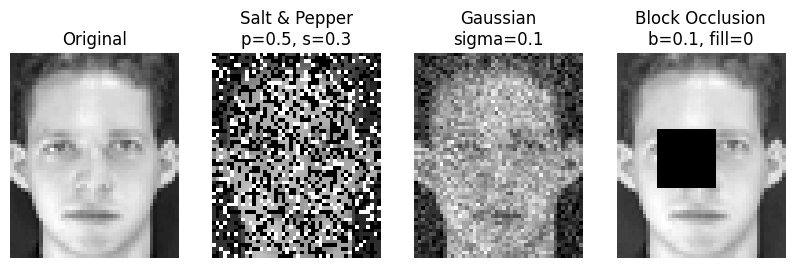

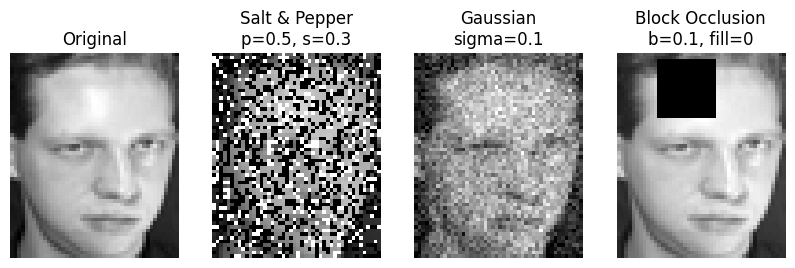

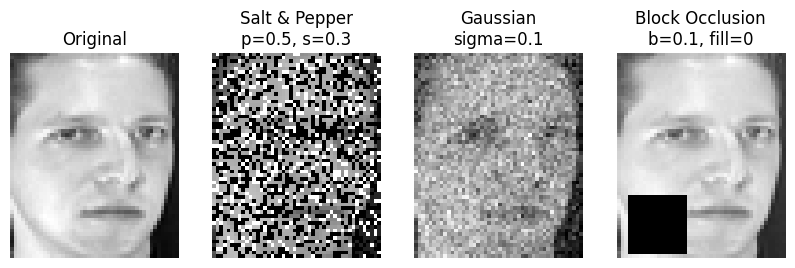

In [ ]:
visualize_noise_comparison_orl(root='data/ORL', reduce=2, p= 0.5, s=0.3, sigma=0.1, b=0.1, fill=0, num_images=3)

#### YaleB

In [ ]:
def visualize_noise_comparison_YaleB(root='data/CroppedYaleB', reduce=4, p= 0.3, s=0.7, sigma=0.5, b=0.3, fill=1, num_images=3):
    """
    Visualize comparison of the first few images before and after adding noise.

    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        block_size: size of the block noise to be added.
        num_images: number of images to visualize.

    Returns:
        None
    """
    image_counter = 0

    for person in sorted(os.listdir(root)):
        if not os.path.isdir(os.path.join(root, person)):
            continue

        for fname in os.listdir(os.path.join(root, person)):
            if not fname.endswith('.pgm') or fname.endswith('Ambient.pgm'):
                continue

            # Load original image
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L')
            img = img.resize([s // reduce for s in img.size])
            img = np.asarray(img) / 255.0


            # Add noise
            noisy_img_salt_and_pepper = add_salt_and_pepper_noise(img, p, s)

            noisy_img_gaussian = add_gaussian_noise(img, sigma)

            noisy_img_block = add_block_occlusion(img, b, fill)

            # Plot original and noisy image
            fig, axs = plt.subplots(1, 4, figsize=(10, 5))
            axs[0].imshow(img, cmap='gray')
            axs[0].set_title('Original')
            axs[0].axis('off')

            axs[1].imshow(noisy_img_salt_and_pepper, cmap='gray')
            axs[1].set_title(f'Salt & Pepper\np={p}, s={s}')
            axs[1].axis('off')


            axs[2].imshow(noisy_img_gaussian, cmap='gray')
            axs[2].set_title(f'Gaussian\nsigma={sigma}')
            axs[2].axis('off')

            axs[3].imshow(noisy_img_block, cmap='gray')
            axs[3].set_title(f'Block Occlusion\nb={b}, fill={fill}')
            axs[3].axis('off')

            plt.show()

            image_counter += 1
            if image_counter >= num_images:
                return

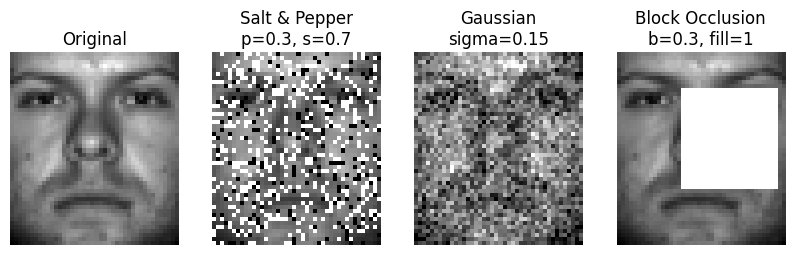

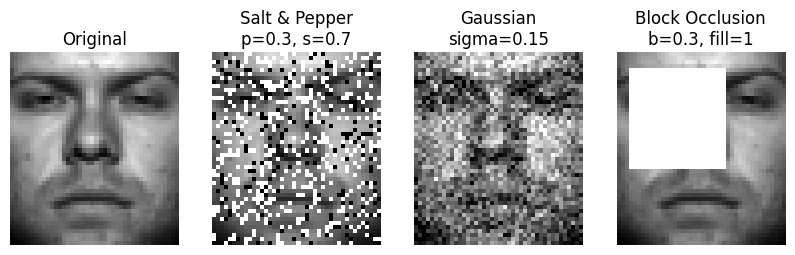

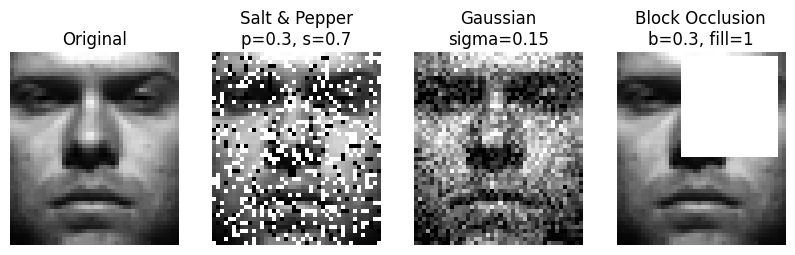

In [ ]:
visualize_noise_comparison_YaleB(root='data/CroppedYaleB', reduce=4, p= 0.3, s=0.7, sigma=0.15, b=0.3, fill=1, num_images=3)

---------------------------


## 3. Custom NMF Algorithms


### 3.1 Load data & add noises

In [ ]:
# Load dataset.
print('==> Load ORL dataset ...')
X_hat_orl, Y_hat_orl = load_data('data/ORL', reduce=3)
print('X_hat.shape={}, Y_hat.shape={}'.format(X_hat_orl.shape, Y_hat_orl.shape))

print('\n==> Load YaleB dataset ...')
X_hat_yale, Y_hat_yale = load_data('data/CroppedYaleB', reduce=4)
print('X_hat.shape={}, Y_hat.shape={}'.format(X_hat_yale.shape, Y_hat_yale.shape))

==> Load ORL dataset ...
X_hat.shape=(1110, 400), Y_hat.shape=(400,)

==> Load YaleB dataset ...
X_hat.shape=(2016, 2414), Y_hat.shape=(2414,)


In [ ]:
def add_noise_to_matrix(X_hat, height, width, noiser):
    D, N = X_hat.shape
    assert D == height * width, f"H*W={height*width} have to equal D={D}"
    X = np.empty_like(X_hat)
    for i in range(N):
        img = X_hat[:, i].reshape(height, width)
        X[:, i] = noiser(img).reshape(-1)
    return X

### 3.2 L2-Norm NMF

In [ ]:
def l2_nmf(X, k, max_iter=500, tol=1e-4, eps=1e-8, seed=None):
    rng = np.random.default_rng(seed)
    D_dim, N = X.shape
    D = rng.random((D_dim, k)) + 1e-4
    R = rng.random((k, N)) + 1e-4

    prev = np.inf
    for it in range(max_iter):
        # R ← R ⊙ (DᵀV) / (DᵀDR)
        R *= (D.T @ X) / (D.T @ (D @ R) + eps)

        # D ← D ⊙ (VRᵀ) / (DRRᵀ)
        D *= (X @ R.T) / (D @ (R @ R.T) + eps)

        scale = np.linalg.norm(D, axis=0) + eps
        D /= scale
        R *= scale[:, None]

        # Every 10 iterations check relative decrease
        if it % 10 == 0 or it == max_iter - 1:
            loss = np.linalg.norm(X - D @ R, 'fro')**2
            if not np.isfinite(loss):
                break
            if np.isfinite(prev):
                rel_drop = (prev - loss) / max(prev, 1.0)
                if rel_drop < tol:
                    break
            prev = loss
    return D, R

### 3.3 L21_Norm_NMF

In [ ]:
def L21_Norm_NMF(X,r,Iter,Convergent,Y=Y_hat_orl):

    np.random.seed(0)
    m, n = X.shape
    # Initialize D, R
    D = np.random.rand(m, r)
    R = np.random.rand(r, n)
    eps = 1e-10  # Handle division by zero

    for i in range(Iter):
        # Compute the residual matrix R
        R1 = X - D @ R

        # Diagonal matrix of weights D
        L2_Norm = np.linalg.norm(R1, axis=1) + eps
        D1 = np.diag(1 / (2*L2_Norm))

        R = R * (D.T @ D1 @ X) / (D.T @ D1 @ D @ R + eps)
        D = D * (D1 @ X @ R.T) / (D1 @ D @ R @ R.T + eps)

        # Compute the loss and print it every 10 iterations
        loss = np.sum(L2_Norm)
        if i % 10 == 0:
            #print(f"Iter {i}, loss = {loss:.4f}")
            # Evaluate relative reconstruction errors.
            #print('==> Evaluate RRE ...')
            # RRE = np.linalg.norm(V_hat - W.dot(H)) / np.linalg.norm(V_hat)
            RRE = np.linalg.norm(X - D.dot(R)) / np.linalg.norm(X)
            #print(f"Iter {i}, RRE = {RRE:.4f}\n")
            # Assign cluster labels.
            Y_pred = assign_cluster_label(R.T, Y)
            acc = accuracy_score(Y, Y_pred)
            nmi = normalized_mutual_info_score(Y, Y_pred)
            #print(f"Iter {i}")
            #print('Acc(NMI) = {:.4f} ({:.4f})\n'.format(acc, nmi))

        # Check whether it converges
        if loss < Convergent:
            break

    return D, R

### 3.4 Hypersurface Cost Based NMF

In [ ]:
def rnmf(X, k, max_iter=150, tol=1e-4, eps=1e-8, seed=None):
    """
    Inplementing the Hypersurface Cost Based NMF algorithm. "rnmf" is the abbreviation of "Robust NMF",
    which is an alternative (and short) name of the algorithm, proposed in the original paper.
    """
    rng = np.random.default_rng(seed)
    D_dim, N = X.shape
    D = rng.random((D_dim, k)) + 1e-4
    R = rng.random((k, N)) + 1e-4

    # calculate the cost func ρ in previous iteration
    prev_cost = _cost_function(X, D, R)
    prev = prev_cost # for checking decreases every 10 iterations
    for it in range(max_iter):
        # alternatively updating values of parameters, first R then D
        cost = _cost_function(X, D, R)
        gradient_R = (D.T @ D @ R - D.T @ X) / (cost+1) # !
        beta = _line_search(cost, X, D, R, gradient_R, 'R', min_params=eps)
        R = np.maximum(R-beta*gradient_R, eps) # prevent parameters from going too small or even negative

        cost = _cost_function(X, D, R)
        gradient_D = (D @ R @ R.T - X @ R.T) / (cost+1) # !
        alpha = _line_search(cost, X, D, R, gradient_D, 'D', min_params=eps)
        D = np.maximum(D-alpha*gradient_D, eps) # prevent parameters from going too small or even negative

        prev_cost = _cost_function(X, D, R)

        if not np.isfinite(prev_cost):
            break
        if np.isfinite(prev):
            rel_drop = (prev - prev_cost) / max(prev, 1.0)
            if rel_drop < tol:
                break
        prev = prev_cost
    return D, R

def _cost_function(X, D, R):
    """
    Value of hypersurface cost function, which is the objective function of the RNMF algorithm.
    """
    return np.sqrt(1+np.linalg.norm(X - D @ R, 'fro')**2) - 1

def _line_search(f_x, X, D, R, gradient, param, min_params):
    """
    Backtracking line search for determining the step sizes for optimizing D and R using Armijo Condition.

    Args:
        f_x: value of cost function
        X, D, R: matrices during NMF calculation
        gradient: gredient matrix during NMF calculation
        param: char, indicator of which parameter to be updated (D or R)

    Returns:
        step: step size.
    """
    step0 = 1.0
    c = 1e-4 # 0.5
    max_iter = 150
    min_step = 1e-12
    tau = 0.5
    # m = gradient.dot(p), assume p is the opposite direction of the gradient
    m = -np.linalg.norm(gradient, 'fro')**2
    t = -c * m
    step = step0
    assert param == 'D' or param == 'R'
    for _ in range(max_iter):
        if step <= min_step:
          return min_step
        new_f_x = 0
        if param == 'D':
          D_test = np.maximum(D-step*gradient, min_params)
          new_f_x = _cost_function(X, D_test, R)
        elif param == 'R':
          R_test = np.maximum(R-step*gradient, min_params)
          new_f_x = _cost_function(X, D, R_test)
        if (f_x - new_f_x) >= step * t:
          return step
        else:
          step *= tau

## 4. Evaluation Metrics


### 4.1 Relative Reconstruction Errors (RRE)

To compare the robustness of different NMF algorithms, you can use the ```relative reconstruction errors```. Let $V$ denote the contaminated dataset (by adding noise), and $\hat{V}$
 denote the clean dataset. Let $W$ and $H$ denote the factorization results on $V$, the ``relative reconstruction errors`` then can be defined as follows:

 \begin{equation}
    RRE = \frac{ \| \hat{V} - WH \|_F }{ \| \hat{V} \|_F}.
\end{equation}


In [ ]:
def eval_one_noise(X_hat, Y_hat, Dd, Rr, noiser, k, algorithm, repeats=5, show_index=2):

    RREs, ACCs, NMIs = [], [], []
    example_img = None
    R_shape = D_shape = None
    subset_ratio = 0.9

    T_S = X_hat.shape[1]

    for rep in range(repeats):
        Rn = int(np.floor(subset_ratio * T_S))
        index = np.random.choice(T_S, Rn, replace=False)
        X_Sub = X_hat[:, index]
        Y_Sub = Y_hat[index]

        # 1) add noise
        X = add_noise_to_matrix(X_Sub, Dd, Rr, noiser)
        example_img = X[:, show_index].reshape(Dd, Rr)

        # 2) L2-NMF
        Rm, Dm = algorithm(X, k=k, max_iter=150, tol=1e-4, seed=rep, Y=Y_Sub)
        R_shape, D_shape = Rm.shape, Dm.shape

        # 3) RRE
        RRE = np.linalg.norm(X_Sub - Rm @ Dm, 'fro') / np.linalg.norm(X_Sub, 'fro')
        RREs.append(RRE)

        # 4) clustering metrics
        y_pred_raw = KMeans(n_clusters=k, n_init=10, random_state=rep).fit_predict(Dm.T)
        NMIs.append(normalized_mutual_info_score(Y_Sub, y_pred_raw))

        # Acc
        Y_pred_majority = assign_cluster_label(Dm.T, Y_Sub)
        ACCs.append(float(np.mean(Y_pred_majority == Y_Sub)))

    return RREs, ACCs, NMIs, example_img, R_shape, D_shape


### 3.2 Evaluate Clustering Performance

1. Accuracy.
    
    $$ Acc(Y, Y_{pred}) = \frac{1}{n}\sum\limits_{i=1}^n 1\{Y_{pred}(i) == Y(i)\}$$
        
2. Normalized Mutual Information (NMI).

    $$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})} $$
    
   where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot) $ is entropy.

In [ ]:
def assign_cluster_label(X, Y):
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred

In [ ]:
sigma = 0.10
noiser_gaussian = lambda img, sigma=sigma: add_gaussian_noise(img, sigma)

D_orl, R_orl = 37, 30

algorithms = []
if 'l2_nmf' in globals():
    algorithms.append(("L2-NMF",lambda X, k, max_iter=150, tol=1e-4, seed=0, **kwargs: l2_nmf(X, k, max_iter=max_iter, tol=tol, seed=seed)))

if 'L21_Norm_NMF' in globals():
    algorithms.append(("L21-NMF",lambda X, k, max_iter=150, tol=1e-4, seed=0, Y=None, **kwargs: L21_Norm_NMF(X, r=k, Iter=max_iter, Convergent=tol, Y=Y)))

if 'rnmf' in globals():
    algorithms.append(("RNMF",lambda X, k, max_iter=150, tol=1e-4, seed=0, **kwargs: rnmf(X, k, max_iter=max_iter, tol=tol, seed=seed)))

ks = list(range(10, 151, 10))
repeats = 5

results = {
    name: {"k": [], "ACC": [], "ACC_sd": [], "NMI": [], "NMI_sd": [], "RRE": [], "RRE_sd": []}
    for name, _ in algorithms
}

for name, fn in algorithms:
    for k in ks:
        RREs, ACCs, NMIs, _, _, _ = eval_one_noise(
            X_hat_orl, Y_hat_orl, D_orl, R_orl,
            noiser=noiser_gaussian, k=k, algorithm=fn,
            repeats=repeats, show_index=2
        )
        rre_m = np.mean(RREs); rre_sd = np.std(RREs, ddof=1)
        acc_m = np.mean(ACCs); acc_sd = np.std(ACCs, ddof=1)
        nmi_m = np.mean(NMIs); nmi_sd = np.std(NMIs, ddof=1)

        results[name]["k"].append(k)
        results[name]["ACC"].append(acc_m); results[name]["ACC_sd"].append(acc_sd)
        results[name]["NMI"].append(nmi_m); results[name]["NMI_sd"].append(nmi_sd)
        results[name]["RRE"].append(rre_m); results[name]["RRE_sd"].append(rre_sd)

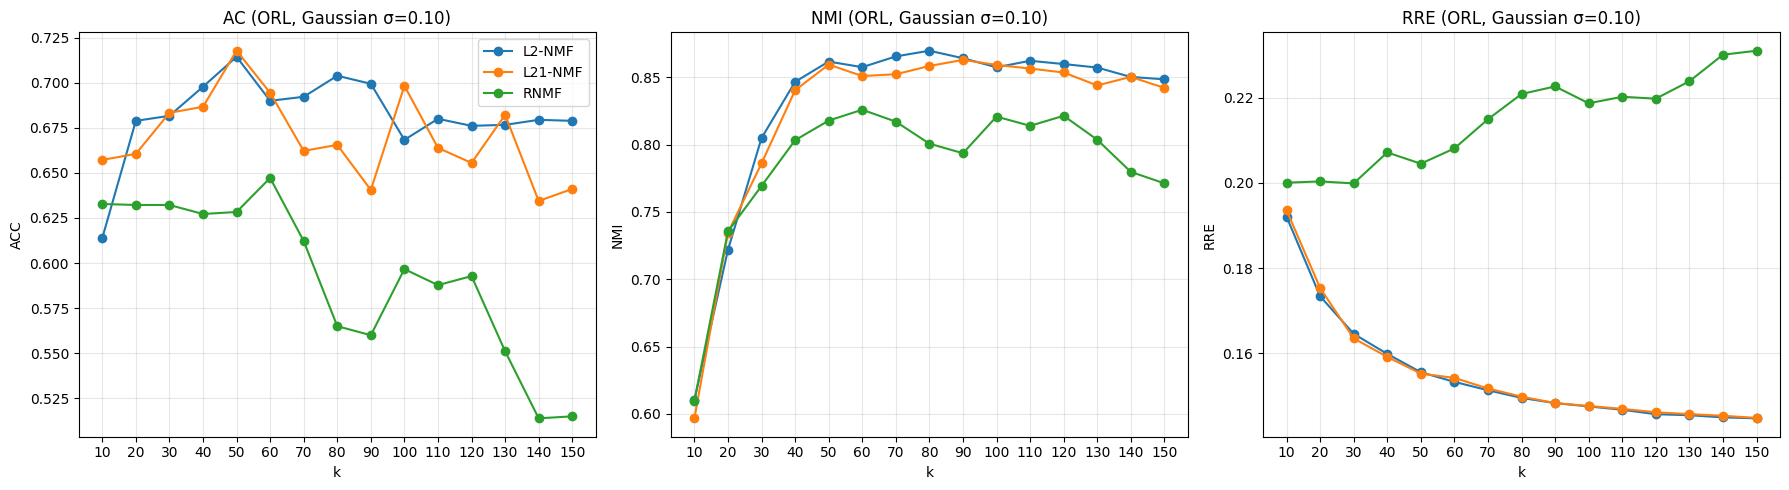

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
metric_specs = [("ACC","AC (ORL, Gaussian σ=0.10)"),
                ("NMI","NMI (ORL, Gaussian σ=0.10)"),
                ("RRE","RRE (ORL, Gaussian σ=0.10)")]
for ax, (metric, title) in zip(axes, metric_specs):
    for name in results.keys():
        ax.plot(results[name]["k"], results[name][metric], marker='o', label=name)
    ax.set_title(title)
    ax.set_xlabel("k"); ax.set_ylabel(metric); ax.set_xticks(ks)
    ax.grid(True, alpha=0.3)
axes[0].legend();
plt.tight_layout();
plt.show()

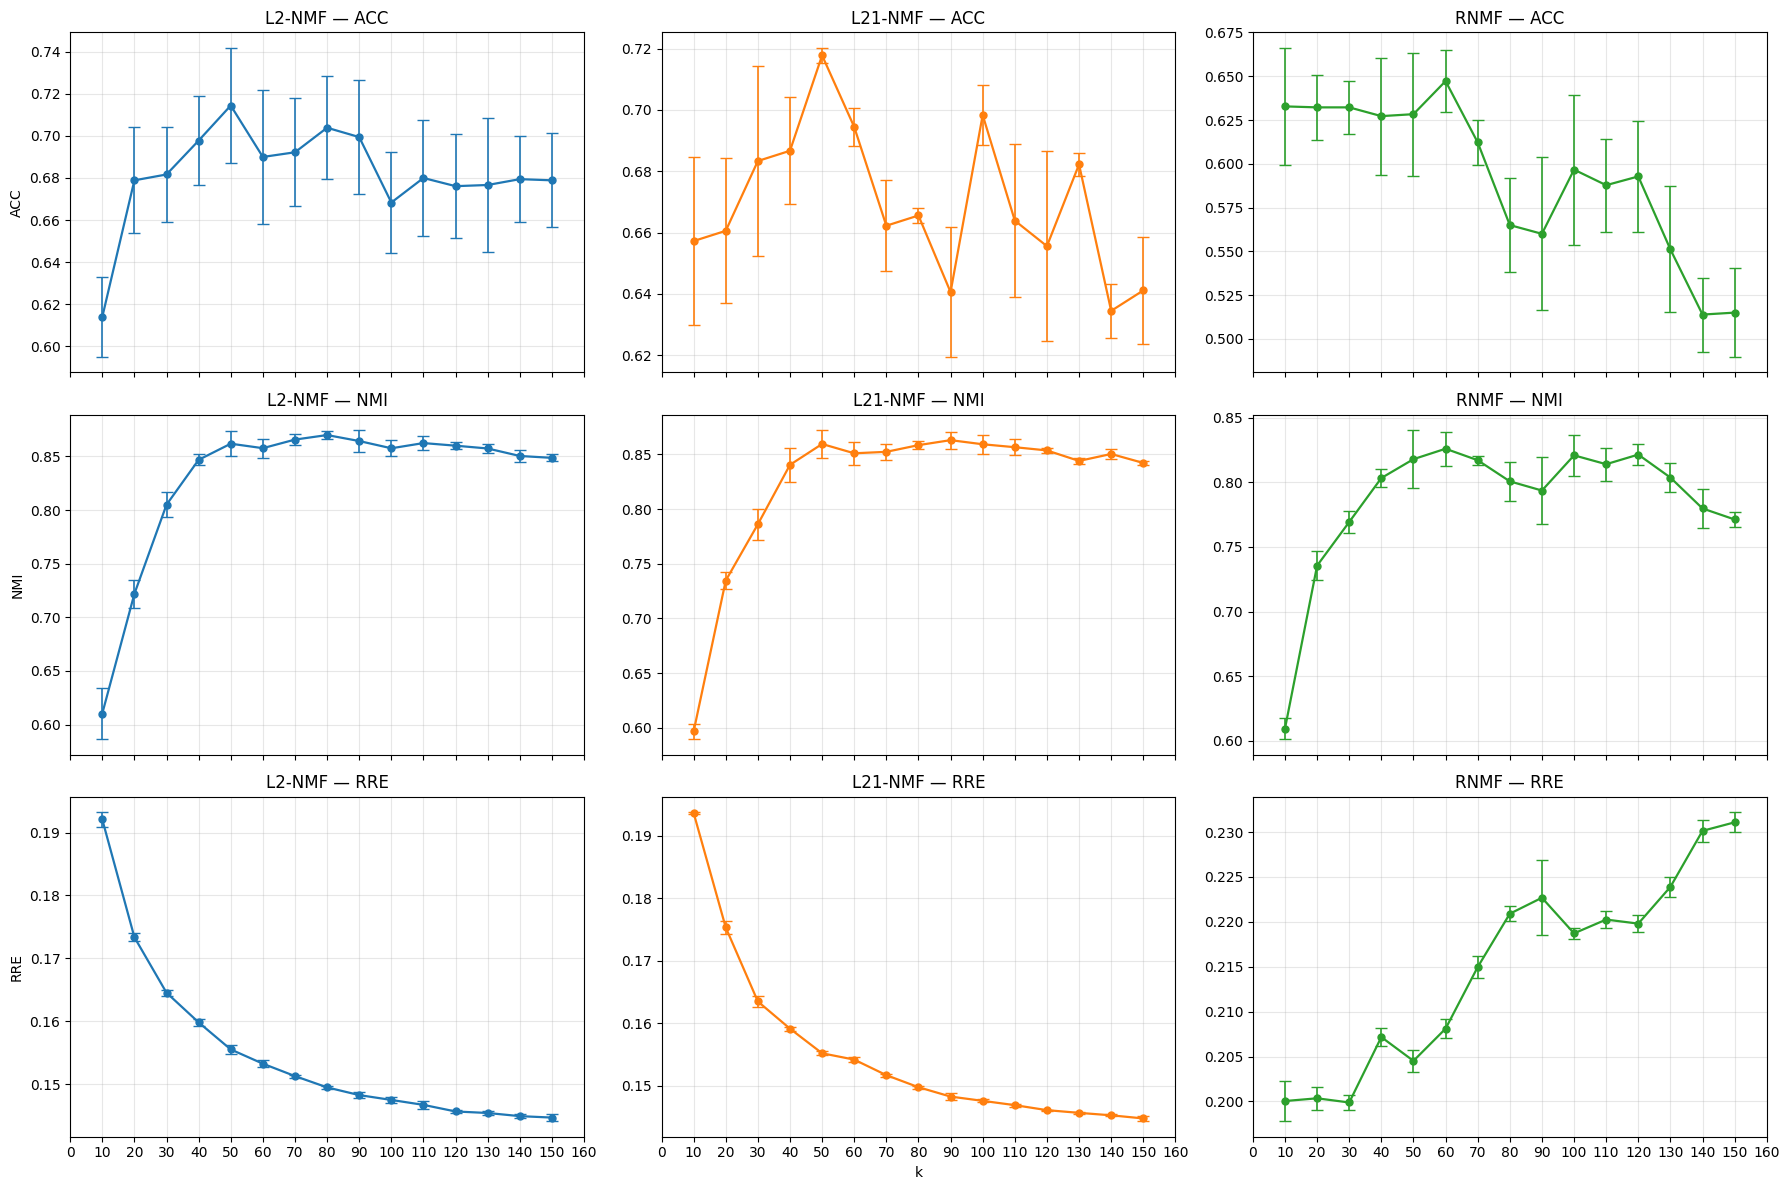

In [24]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=True)

metric_specs = [("ACC", "ACC"), ("NMI", "NMI"), ("RRE", "RRE")]
alg_order = [name for name in ["L2-NMF", "L21-NMF", "RNMF"] if name in results]
color_map = {"L2-NMF": "tab:blue", "L21-NMF": "tab:orange", "RNMF": "tab:green"}

for r, (metric, ylab) in enumerate(metric_specs):
    for c, name in enumerate(alg_order):
        ax = axes[r, c]
        if name is not None:
            x = np.array(results[name]["k"], dtype=float)                    # 10..150
            y = np.array(results[name][metric], dtype=float)                 # mean
            sd = np.array(results[name][f"{metric}_sd"], dtype=float)        # SD

            ax.errorbar(
                x, y, yerr=sd,
                fmt='o-', lw=1.6, ms=5, capsize=4,
                color=color_map[name], ecolor=color_map[name], elinewidth=1.2
            )
            ax.set_title(f"{name} — {metric}")
        ax.set_xlim(0, 150)
        ax.set_xticks(range(0, 161, 10))
        ax.grid(True, alpha=0.3)
        if c == 0:
            ax.set_ylabel(ylab)

axes[-1, 1].set_xlabel("k")
plt.tight_layout()
plt.show()


In [ ]:
D_orl,  R_orl  = 37, 30
D_yale, R_yale = 48, 42
k_fixed = 60
repeats = 5 

# ps: 0.1 0.6, 0.4 0.6, 0.8 0.6
p_vals = [0.1, 0.4, 0.8]
s   = 0.6
# 0.05 0.1 0.15
sigma_vals = [0.05, 0.10, 0.15]
# 20% 40% 70%
b_vals = [0.2, 0.4, 0.7]
fill = 1.0

datasets = {
    "ORL":  (X_hat_orl,  Y_hat_orl,  D_orl,  R_orl),
    "Yale": (X_hat_yale, Y_hat_yale, D_yale, R_yale),
}

def collect_results_for_algorithm(alg_name_to_run):
    
    alg_map = {name: fn for name, fn in algorithms}

    alg_fn = alg_map[alg_name_to_run]

    all_results_sub = {ds: {"pepper": {}, "gaussian": {}, "block": {}} for ds in datasets}
    box_results_sub = {ds: {"pepper": {}, "gaussian": {}, "block": {}} for ds in datasets}

    for ds_name, (Xh, Yh, Dd, Rr) in datasets.items():
        # 1) pepper
        for p in p_vals:
            noiser_pepper = (lambda img, p=p, s=s: add_salt_and_pepper_noise(img, p, s))
            RREs, ACCs, NMIs, *_ = eval_one_noise(
                Xh, Yh, Dd, Rr,
                noiser=noiser_pepper, k=k_fixed, algorithm=alg_fn,
                repeats=repeats, show_index=2
            )
            
            box_results_sub[ds_name]["pepper"][(p, s)] = {
                "ACC": np.asarray(ACCs, dtype=float),
                "NMI": np.asarray(NMIs, dtype=float),
                "RRE": np.asarray(RREs, dtype=float),
                "ACC_m": np.mean(ACCs), "ACC_sd": np.std(ACCs, ddof=1),
                "NMI_m": np.mean(NMIs), "NMI_sd": np.std(NMIs, ddof=1),
                "RRE_m": np.mean(RREs), "RRE_sd": np.std(RREs, ddof=1),
            }
            all_results_sub[ds_name]["pepper"][(p, s)] = {
                "ACC": box_results_sub[ds_name]["pepper"][(p, s)]["ACC_m"],
                "ACC_sd": box_results_sub[ds_name]["pepper"][(p, s)]["ACC_sd"],
                "NMI": box_results_sub[ds_name]["pepper"][(p, s)]["NMI_m"],
                "NMI_sd": box_results_sub[ds_name]["pepper"][(p, s)]["NMI_sd"],
                "RRE": box_results_sub[ds_name]["pepper"][(p, s)]["RRE_m"],
                "RRE_sd": box_results_sub[ds_name]["pepper"][(p, s)]["RRE_sd"],
            }

        # 2) gaussian
        for sigma in sigma_vals:
            noiser_gaussian = (lambda img, sigma=sigma: add_gaussian_noise(img, sigma))
            RREs, ACCs, NMIs, *_ = eval_one_noise(
                Xh, Yh, Dd, Rr,
                noiser=noiser_gaussian, k=k_fixed, algorithm=alg_fn,
                repeats=repeats, show_index=2
            )
            box_results_sub[ds_name]["gaussian"][(sigma,)] = {
                "ACC": np.asarray(ACCs, dtype=float),
                "NMI": np.asarray(NMIs, dtype=float),
                "RRE": np.asarray(RREs, dtype=float),
                "ACC_m": np.mean(ACCs), "ACC_sd": np.std(ACCs, ddof=1),
                "NMI_m": np.mean(NMIs), "NMI_sd": np.std(NMIs, ddof=1),
                "RRE_m": np.mean(RREs), "RRE_sd": np.std(RREs, ddof=1),
            }
            all_results_sub[ds_name]["gaussian"][(sigma,)] = {
                "ACC": box_results_sub[ds_name]["gaussian"][(sigma,)]["ACC_m"],
                "ACC_sd": box_results_sub[ds_name]["gaussian"][(sigma,)]["ACC_sd"],
                "NMI": box_results_sub[ds_name]["gaussian"][(sigma,)]["NMI_m"],
                "NMI_sd": box_results_sub[ds_name]["gaussian"][(sigma,)]["NMI_sd"],
                "RRE": box_results_sub[ds_name]["gaussian"][(sigma,)]["RRE_m"],
                "RRE_sd": box_results_sub[ds_name]["gaussian"][(sigma,)]["RRE_sd"],
            }

        # 3) block
        for b in b_vals:
            noiser_block = (lambda img, b=b, fill=fill: add_block_occlusion(img, b, fill))
            RREs, ACCs, NMIs, *_ = eval_one_noise(
                Xh, Yh, Dd, Rr,
                noiser=noiser_block, k=k_fixed, algorithm=alg_fn,
                repeats=repeats, show_index=2
            )
            box_results_sub[ds_name]["block"][(b, fill)] = {
                "ACC": np.asarray(ACCs, dtype=float),
                "NMI": np.asarray(NMIs, dtype=float),
                "RRE": np.asarray(RREs, dtype=float),
                "ACC_m": np.mean(ACCs), "ACC_sd": np.std(ACCs, ddof=1),
                "NMI_m": np.mean(NMIs), "NMI_sd": np.std(NMIs, ddof=1),
                "RRE_m": np.mean(RREs), "RRE_sd": np.std(RREs, ddof=1),
            }
            all_results_sub[ds_name]["block"][(b, fill)] = {
                "ACC": box_results_sub[ds_name]["block"][(b, fill)]["ACC_m"],
                "ACC_sd": box_results_sub[ds_name]["block"][(b, fill)]["ACC_sd"],
                "NMI": box_results_sub[ds_name]["block"][(b, fill)]["NMI_m"],
                "NMI_sd": box_results_sub[ds_name]["block"][(b, fill)]["NMI_sd"],
                "RRE": box_results_sub[ds_name]["block"][(b, fill)]["RRE_m"],
                "RRE_sd": box_results_sub[ds_name]["block"][(b, fill)]["RRE_sd"],
            }

    return all_results_sub, box_results_sub

In [29]:
all_results_L2,  box_results_L2  = collect_results_for_algorithm("L2-NMF")

In [30]:
print(all_results_L2, box_results_L2)

{'ORL': {'pepper': {(0.1, 0.6): {'ACC': 0.5888888888888888, 'ACC_sd': 0.02365192550823112, 'NMI': 0.7840411854280468, 'NMI_sd': 0.015281573664664858, 'RRE': 0.20791428468351017, 'RRE_sd': 0.0005772989683284484}, (0.4, 0.6): {'ACC': 0.22944444444444442, 'ACC_sd': 0.010130323627116933, 'NMI': 0.5020262647032151, 'NMI_sd': 0.005332690685756306, 'RRE': 0.3956660705199457, 'RRE_sd': 0.0018576583271294159}, (0.8, 0.6): {'ACC': 0.18333333333333332, 'ACC_sd': 0.010936122047238634, 'NMI': 0.4809164194126815, 'NMI_sd': 0.0049119831060279034, 'RRE': 0.5789447677898245, 'RRE_sd': 0.002705977638474019}}, 'gaussian': {(0.05,): {'ACC': 0.7294444444444446, 'ACC_sd': 0.017190831607517554, 'NMI': 0.8732814539104788, 'NMI_sd': 0.009096906710745175, 'RRE': 0.13804045299064333, 'RRE_sd': 0.0003132598712720703}, (0.1,): {'ACC': 0.705, 'ACC_sd': 0.033066058088784406, 'NMI': 0.8555353374907343, 'NMI_sd': 0.012295268769655582, 'RRE': 0.1528475778248189, 'RRE_sd': 0.0007183779448315073}, (0.15,): {'ACC': 0.6516

In [ ]:
import os, json, numpy as np

def _key_to_str(k):
    
    if isinstance(k, tuple):
        return "(" + ",".join(str(x) for x in k) + ")"
    return str(k)

def to_jsonable(obj):
    if isinstance(obj, dict):
        return {_key_to_str(k): to_jsonable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [to_jsonable(x) for x in obj]
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, (np.floating,)):
        return float(obj)
    if isinstance(obj, (np.integer,)):
        return int(obj)
    return obj

save_dir = "./exports"; os.makedirs(save_dir, exist_ok=True)

with open(os.path.join(save_dir, "all_results_L2.txt"), "w", encoding="utf-8") as f:
    json.dump(to_jsonable(all_results_L2), f, ensure_ascii=False, indent=2)

with open(os.path.join(save_dir, "box_results_L2.txt"), "w", encoding="utf-8") as f:
    json.dump(to_jsonable(box_results_L2), f, ensure_ascii=False, indent=2)

print("Saved L2:", os.path.abspath(os.path.join(save_dir, "all_results_L2.txt")))
print("Saved L2:", os.path.abspath(os.path.join(save_dir, "box_results_L2.txt")))


Saved L2: e:\5328 Assignment\USYD_5328\Assignment1\exports\all_results_L2.txt
Saved L2: e:\5328 Assignment\USYD_5328\Assignment1\exports\box_results_L2.txt


In [31]:
all_results_L21, box_results_L21 = collect_results_for_algorithm("L21-NMF")

In [32]:
print(all_results_L21, box_results_L21)

{'ORL': {'pepper': {(0.1, 0.6): {'ACC': 0.5650000000000001, 'ACC_sd': 0.0024845199749997577, 'NMI': 0.7520193141656817, 'NMI_sd': 0.014170422960791244, 'RRE': 0.20776012440255615, 'RRE_sd': 0.00011952884353846336}, (0.4, 0.6): {'ACC': 0.23888888888888887, 'ACC_sd': 3.1031676915590914e-17, 'NMI': 0.509674849166714, 'NMI_sd': 0.005675923269674665, 'RRE': 0.39320926707519493, 'RRE_sd': 0.0}, (0.8, 0.6): {'ACC': 0.18055555555555555, 'ACC_sd': 0.0, 'NMI': 0.48162151229319095, 'NMI_sd': 0.0035356397213633017, 'RRE': 0.5791732608161043, 'RRE_sd': 0.0}}, 'gaussian': {(0.05,): {'ACC': 0.6916666666666667, 'ACC_sd': 0.0, 'NMI': 0.8652940766449397, 'NMI_sd': 0.007672608246045802, 'RRE': 0.1394885940663986, 'RRE_sd': 0.0}, (0.1,): {'ACC': 0.6972222222222222, 'ACC_sd': 0.0, 'NMI': 0.8480077481376265, 'NMI_sd': 0.007179763000200835, 'RRE': 0.154346077662701, 'RRE_sd': 0.0}, (0.15,): {'ACC': 0.6361111111111111, 'ACC_sd': 0.0, 'NMI': 0.8224692576643513, 'NMI_sd': 0.013549863355353815, 'RRE': 0.17933021

In [ ]:
import os, json, numpy as np

def _key_to_str(k):
    if isinstance(k, tuple):
        return "(" + ",".join(str(x) for x in k) + ")"
    return str(k)

def to_jsonable(obj):
    if isinstance(obj, dict):
        return {_key_to_str(k): to_jsonable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [to_jsonable(x) for x in obj]
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, (np.floating,)):
        return float(obj)
    if isinstance(obj, (np.integer,)):
        return int(obj)
    return obj

save_dir = "./exports"; os.makedirs(save_dir, exist_ok=True)

with open(os.path.join(save_dir, "all_results_L21.txt"), "w", encoding="utf-8") as f:
    json.dump(to_jsonable(all_results_L21), f, ensure_ascii=False, indent=2)

with open(os.path.join(save_dir, "box_results_L21.txt"), "w", encoding="utf-8") as f:
    json.dump(to_jsonable(box_results_L21), f, ensure_ascii=False, indent=2)

print("Saved L21:", os.path.abspath(os.path.join(save_dir, "all_results_L21.txt")))
print("Saved L21:", os.path.abspath(os.path.join(save_dir, "box_results_L21.txt")))


Saved L21: e:\5328 Assignment\USYD_5328\Assignment1\exports\all_results_L21.txt
Saved L21: e:\5328 Assignment\USYD_5328\Assignment1\exports\box_results_L21.txt


In [38]:
all_results_RNMF, box_results_RNMF = collect_results_for_algorithm("RNMF")

In [39]:
print(all_results_RNMF, box_results_RNMF)

{'ORL': {'pepper': {(0.1, 0.6): {'ACC': 0.5233333333333333, 'ACC_sd': 0.023943735488344414, 'NMI': 0.7358940602426743, 'NMI_sd': 0.019069681896569556, 'RRE': 0.23958315337249186, 'RRE_sd': 0.001132177772453491}, (0.4, 0.6): {'ACC': 0.21944444444444447, 'ACC_sd': 0.010577462647033202, 'NMI': 0.5049616605977834, 'NMI_sd': 0.004732425514838793, 'RRE': 0.34767113741800915, 'RRE_sd': 0.0012734901162761252}, (0.8, 0.6): {'ACC': 0.18, 'ACC_sd': 0.0060220787190774444, 'NMI': 0.4755082382586869, 'NMI_sd': 0.0062496885168590146, 'RRE': 0.47795134332334266, 'RRE_sd': 0.002309267627433575}}, 'gaussian': {(0.05,): {'ACC': 0.6494444444444445, 'ACC_sd': 0.016942167424418814, 'NMI': 0.8405629489170481, 'NMI_sd': 0.015285336408211912, 'RRE': 0.2022116523153704, 'RRE_sd': 0.000961990394535735}, (0.1,): {'ACC': 0.6361111111111111, 'ACC_sd': 0.0174580626249674, 'NMI': 0.8250621199728293, 'NMI_sd': 0.012365730609309821, 'RRE': 0.20828307778788108, 'RRE_sd': 0.001003705352426756}, (0.15,): {'ACC': 0.5905555

In [40]:
import os, json, numpy as np

def _key_to_str(k):
    if isinstance(k, tuple):
        return "(" + ",".join(str(x) for x in k) + ")"
    return str(k)

def to_jsonable(obj):
    if isinstance(obj, dict):
        return {_key_to_str(k): to_jsonable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [to_jsonable(x) for x in obj]
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, (np.floating,)):
        return float(obj)
    if isinstance(obj, (np.integer,)):
        return int(obj)
    return obj

save_dir = "./exports"; os.makedirs(save_dir, exist_ok=True)

with open(os.path.join(save_dir, "all_results_RNMF.txt"), "w", encoding="utf-8") as f:
    json.dump(to_jsonable(all_results_RNMF), f, ensure_ascii=False, indent=2)

with open(os.path.join(save_dir, "box_results_RNMF.txt"), "w", encoding="utf-8") as f:
    json.dump(to_jsonable(box_results_RNMF), f, ensure_ascii=False, indent=2)

print("Saved L21:", os.path.abspath(os.path.join(save_dir, "all_results_RNMF.txt")))
print("Saved L21:", os.path.abspath(os.path.join(save_dir, "box_results_RNMF.txt")))


Saved L21: e:\5328 Assignment\USYD_5328\Assignment1\exports\all_results_RNMF.txt
Saved L21: e:\5328 Assignment\USYD_5328\Assignment1\exports\box_results_RNMF.txt


In [6]:
def _restore_keys(obj):
    if isinstance(obj, dict):
        out = {}
        for k, v in obj.items():
            new_k = k
            if isinstance(k, str):
                try:
                    parsed = ast.literal_eval(k)
                    if isinstance(parsed, (tuple, float, int, bool, type(None))):
                        new_k = parsed
                except Exception:
                    pass
            out[new_k] = _restore_keys(v)
        return out
    elif isinstance(obj, list):
        return [_restore_keys(x) for x in obj]
    else:
        return obj

def _pretty_alg_name(tag: str) -> str:
    tag = tag.strip().upper().replace("_", "-")
    if tag in ("L2", "L2-NMF", "L2NMF"):     return "L2-NMF"
    if tag in ("L21", "L21-NMF", "L21NMF"):  return "L21-NMF"
    if tag in ("RNMF",):                     return "RNMF"
    return tag

def load_all_box_results(export_dir="exports"):
    merged = {}
    for fname in os.listdir(export_dir):
        if not fname.startswith("box_results_") or not fname.endswith(".txt"):
            continue
        tag = fname[len("box_results_"):-len(".txt")]   # e.g. L2 / L21 / RNMF
        alg_name = _pretty_alg_name(tag)
        with open(os.path.join(export_dir, fname), "r", encoding="utf-8") as f:
            data = _restore_keys(json.load(f))          # data[ds][noise][(param)] -> metrics

        for ds, noise_map in data.items():
            ds_dst = merged.setdefault(ds, {})
            for noise, param_map in noise_map.items():
                noise_dst = ds_dst.setdefault(noise, {})
                alg_dst = noise_dst.setdefault(alg_name, {})
                for param_key, metrics in param_map.items():
                    alg_dst[param_key] = metrics
    return merged

box_results = load_all_box_results("exports")

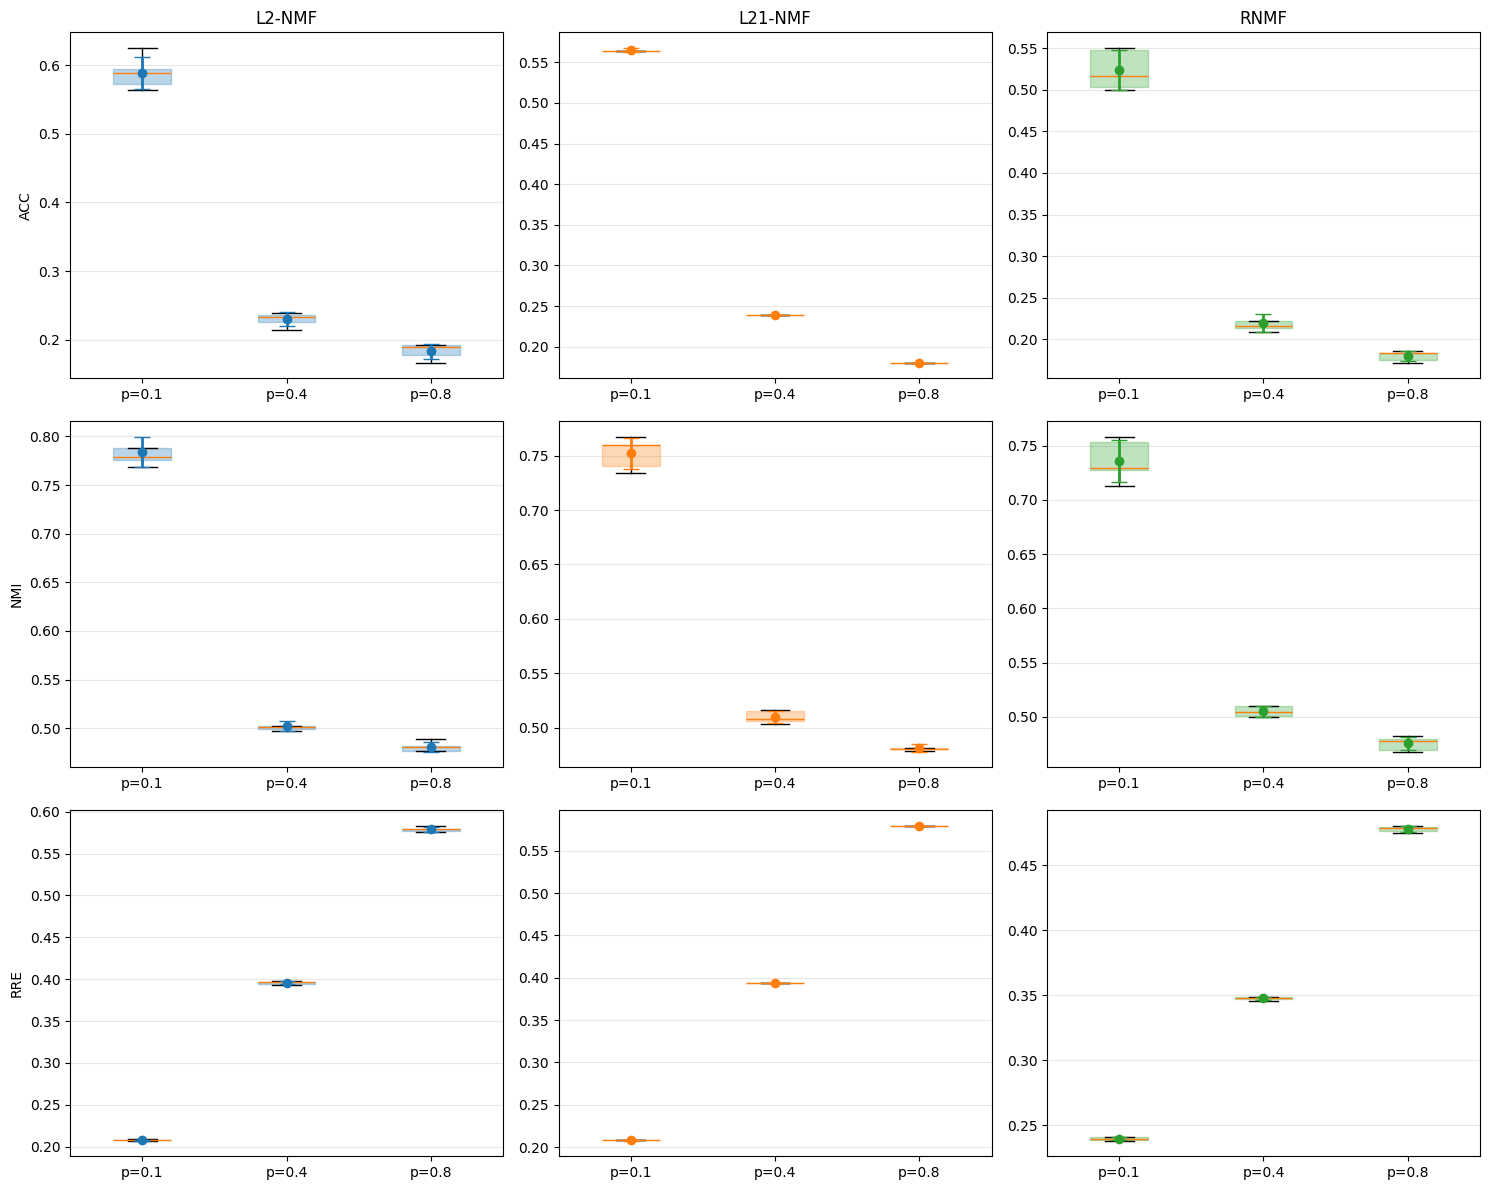

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=False)

metric_rows = [("ACC", "ACC (ORL, pepper)"),
               ("NMI", "NMI (ORL, pepper)"),
               ("RRE", "RRE (ORL, pepper)")]

alg_order = [name for name in ["L2-NMF", "L21-NMF", "RNMF"]
             if name in box_results.get("ORL", {}).get("pepper", {})]

color_map = {"L2-NMF": "tab:blue", "L21-NMF": "tab:orange", "RNMF": "tab:green"}

default_p_vals = [0.05, 0.10, 0.15]
if alg_order:  
    keys0 = list(box_results["ORL"]["pepper"][alg_order[0]].keys())
    p_vals = []
    for k in keys0:
        if isinstance(k, tuple) and len(k) >= 1:
            p_vals.append(float(k[0]))
        elif isinstance(k, (float, int)):
            p_vals.append(float(k))
    p_vals = sorted(set(p_vals))
    if not p_vals:
        p_vals = default_p_vals
else:
    pvals = default_p_vals

pos = [0.2, 0.5, 0.8][:len(p_vals)]
tick_labels = [f"p={p}" for p in p_vals]

for r, (metric, _) in enumerate(metric_rows):
    for c, alg_name in enumerate(alg_order):
        ax = axes[r, c]

        cells, chosen_keys = [], []
        for p in p_vals:
            candidates = []
            for k in box_results["ORL"]["pepper"][alg_name].keys():
                if isinstance(k, tuple) and len(k) >= 1 and np.isclose(float(k[0]), p):
                    candidates.append(k)
                elif isinstance(k, (float, int)) and np.isclose(float(k), p):
                    candidates.append(k)
            if not candidates:
                continue
            key = sorted(candidates, key=lambda t: (t if isinstance(t, tuple) else (t,)))[0]
            chosen_keys.append(key)
            cells.append(np.asarray(box_results["ORL"]["pepper"][alg_name][key][metric], dtype=float))

        if len(cells) == 0:
            ax.set_visible(False)
            continue

        bp = ax.boxplot(
            cells,
            positions=pos[:len(cells)],
            patch_artist=True,
            showfliers=False,
            widths=0.12,
            tick_labels=tick_labels[:len(cells)]
        )
        for patch in bp["boxes"]:
            patch.set_facecolor(color_map[alg_name])
            patch.set_edgecolor(color_map[alg_name])
            patch.set_alpha(0.30)

        for x, key in zip(pos[:len(chosen_keys)], chosen_keys):
            m  = float(box_results["ORL"]["pepper"][alg_name][key][f"{metric}_m"])
            sd = float(box_results["ORL"]["pepper"][alg_name][key][f"{metric}_sd"])
            ax.errorbar(x, m, yerr=sd, fmt="o", ms=6, lw=2,
                        color=color_map[alg_name], capsize=6, zorder=3)

        if r == 0:
            ax.set_title(alg_name)
        if c == 0:
            ax.set_ylabel(metric)
        ax.set_xlim(0.05, 0.95)
        ax.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

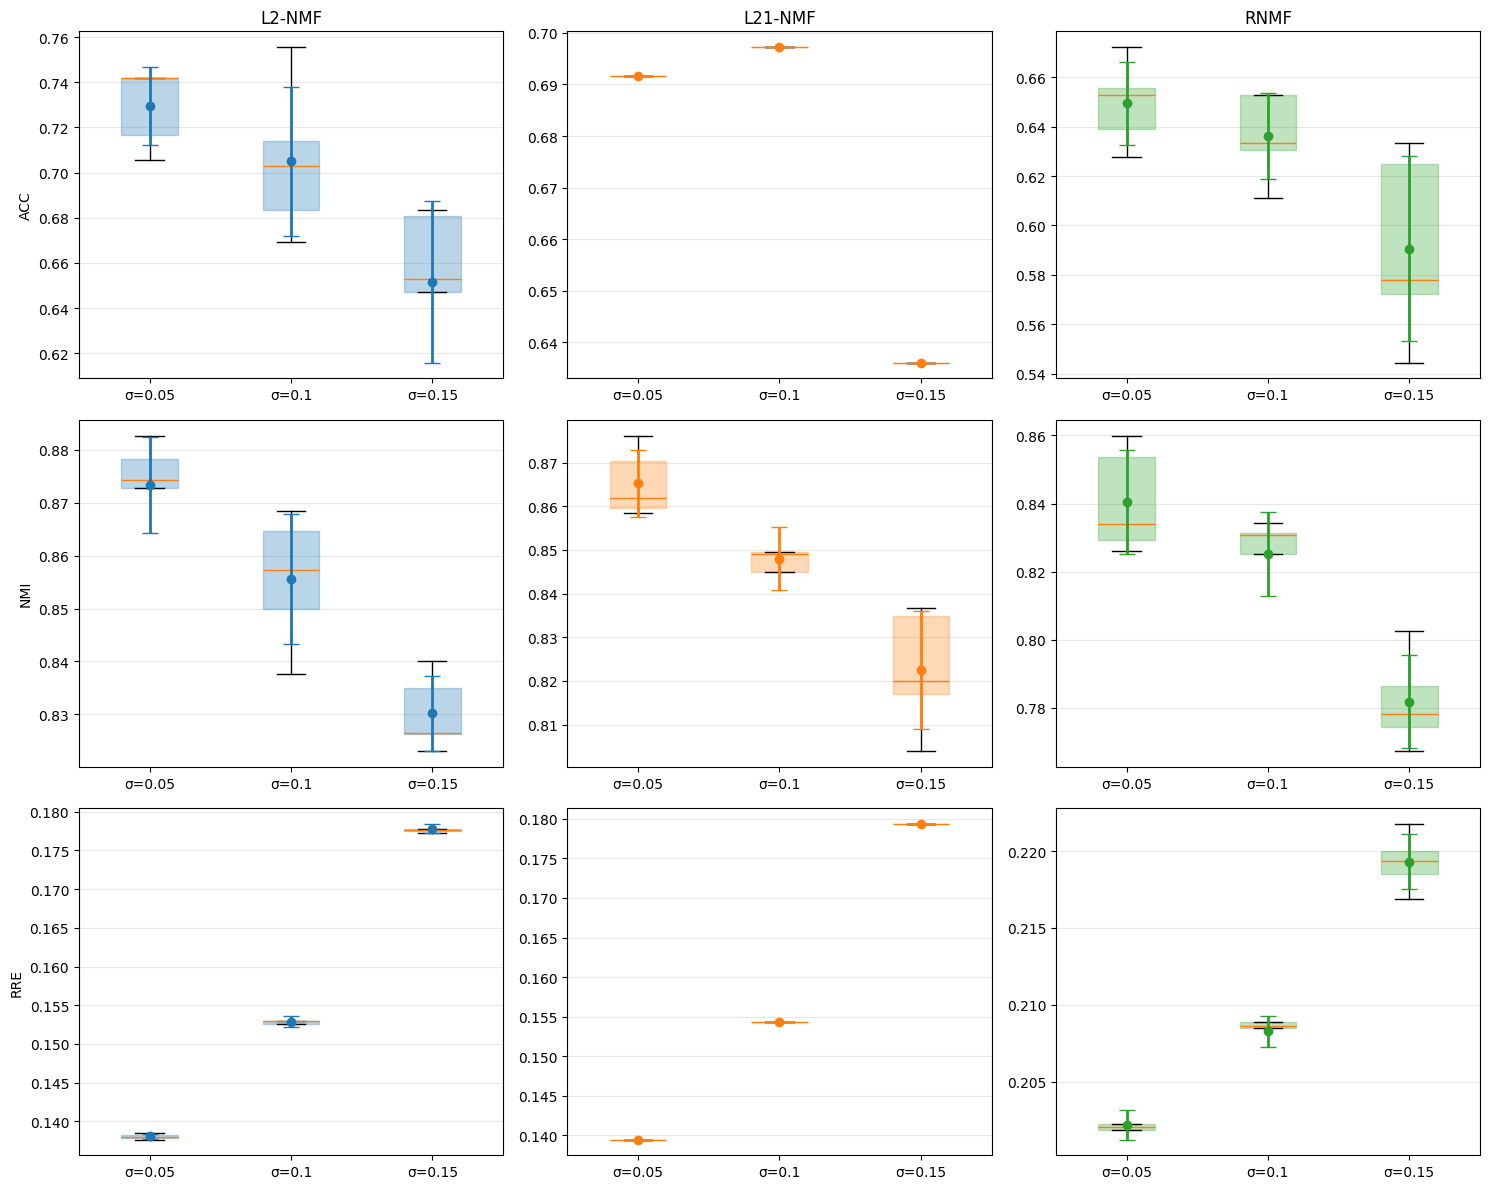

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=False)

metric_rows = [("ACC", "ACC (ORL, Gaussian)"),
               ("NMI", "NMI (ORL, Gaussian)"),
               ("RRE", "RRE (ORL, Gaussian)")]

alg_order = [name for name in ["L2-NMF", "L21-NMF", "RNMF"]
             if name in box_results.get("ORL", {}).get("gaussian", {})]

color_map = {"L2-NMF": "tab:blue", "L21-NMF": "tab:orange", "RNMF": "tab:green"}

default_sigma_vals = [0.05, 0.10, 0.15]
if alg_order:  
    keys0 = list(box_results["ORL"]["gaussian"][alg_order[0]].keys())
    sigma_vals = []
    for k in keys0:
        if isinstance(k, tuple) and len(k) >= 1:
            sigma_vals.append(float(k[0]))
        elif isinstance(k, (float, int)):
            sigma_vals.append(float(k))
    sigma_vals = sorted(set(sigma_vals))
    if not sigma_vals:
        sigma_vals = default_sigma_vals
else:
    sigma_vals = default_sigma_vals

pos = [0.2, 0.5, 0.8][:len(sigma_vals)]
tick_labels = [f"σ={sigma}" for sigma in sigma_vals]

for r, (metric, _) in enumerate(metric_rows):
    for c, alg_name in enumerate(alg_order):
        ax = axes[r, c]

        cells, chosen_keys = [], []
        for sigma in sigma_vals:
            candidates = []
            for k in box_results["ORL"]["gaussian"][alg_name].keys():
                if isinstance(k, tuple) and len(k) >= 1 and np.isclose(float(k[0]), sigma):
                    candidates.append(k)
                elif isinstance(k, (float, int)) and np.isclose(float(k), sigma):
                    candidates.append(k)
            if not candidates:
                continue
            key = sorted(candidates, key=lambda t: (t if isinstance(t, tuple) else (t,)))[0]
            chosen_keys.append(key)
            cells.append(np.asarray(box_results["ORL"]["gaussian"][alg_name][key][metric], dtype=float))

        if len(cells) == 0:
            ax.set_visible(False)
            continue

        bp = ax.boxplot(
            cells,
            positions=pos[:len(cells)],
            patch_artist=True,
            showfliers=False,
            widths=0.12,
            tick_labels=tick_labels[:len(cells)]
        )
        for patch in bp["boxes"]:
            patch.set_facecolor(color_map[alg_name])
            patch.set_edgecolor(color_map[alg_name])
            patch.set_alpha(0.30)

        for x, key in zip(pos[:len(chosen_keys)], chosen_keys):
            m  = float(box_results["ORL"]["gaussian"][alg_name][key][f"{metric}_m"])
            sd = float(box_results["ORL"]["gaussian"][alg_name][key][f"{metric}_sd"])
            ax.errorbar(x, m, yerr=sd, fmt="o", ms=6, lw=2,
                        color=color_map[alg_name], capsize=6, zorder=3)

        if r == 0:
            ax.set_title(alg_name)
        if c == 0:
            ax.set_ylabel(metric)
        ax.set_xlim(0.05, 0.95)
        ax.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

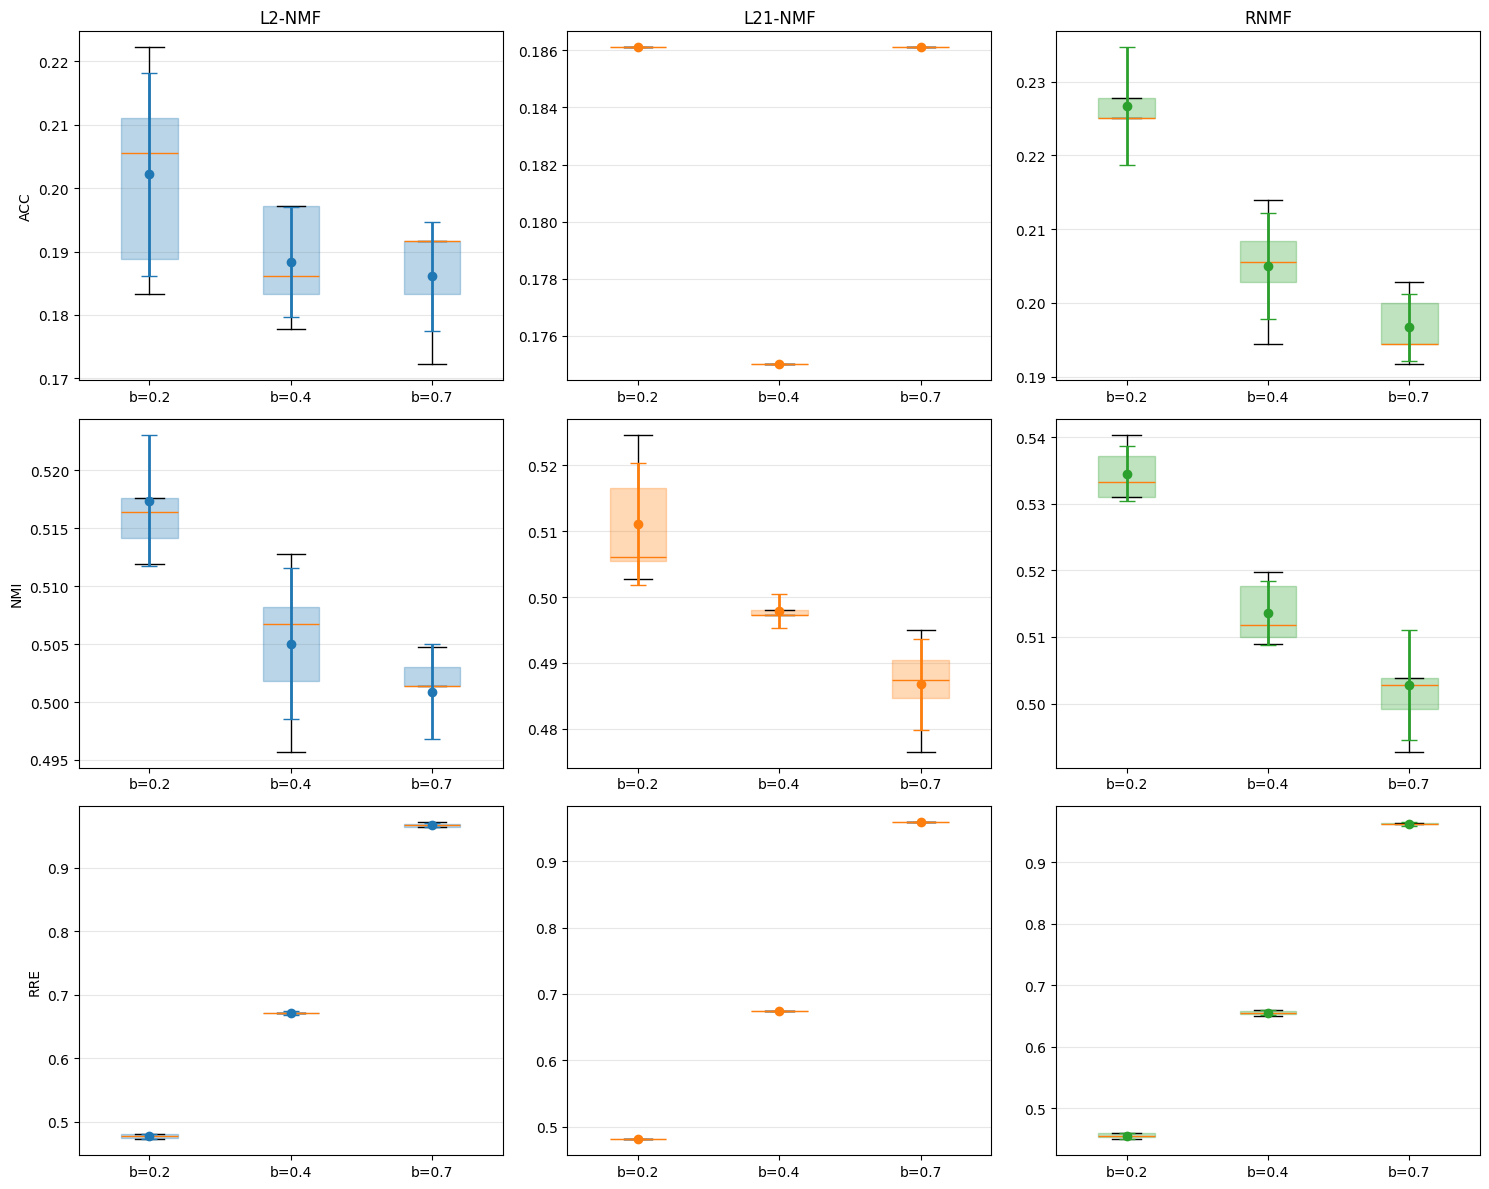

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=False)

metric_rows = [("ACC", "ACC (ORL, Block)"),
               ("NMI", "NMI (ORL, Block)"),
               ("RRE", "RRE (ORL, Block)")]

alg_order = [name for name in ["L2-NMF", "L21-NMF", "RNMF"]
             if name in box_results.get("ORL", {}).get("block", {})]

color_map = {"L2-NMF": "tab:blue", "L21-NMF": "tab:orange", "RNMF": "tab:green"}

default_block_vals = [0.2, 0.4, 0.7]
if alg_order:  
    keys0 = list(box_results["ORL"]["block"][alg_order[0]].keys())
    block_vals = []
    for k in keys0:
        if isinstance(k, tuple) and len(k) >= 1:
            block_vals.append(float(k[0]))
        elif isinstance(k, (float, int)):
            block_vals.append(float(k))
    block_vals = sorted(set(block_vals))
    if not block_vals:
        block_vals = default_block_vals
else:
    block_vals = default_block_vals

pos = [0.2, 0.5, 0.8][:len(block_vals)]
tick_labels = [f"b={b}" for b in block_vals]

for r, (metric, _) in enumerate(metric_rows):
    for c, alg_name in enumerate(alg_order):
        ax = axes[r, c]

        cells, chosen_keys = [], []
        for b in block_vals:
            candidates = []
            for k in box_results["ORL"]["block"][alg_name].keys():
                if isinstance(k, tuple) and len(k) >= 1 and np.isclose(float(k[0]), b):
                    candidates.append(k)
                elif isinstance(k, (float, int)) and np.isclose(float(k), b):
                    candidates.append(k)
            if not candidates:
                continue
            key = sorted(candidates, key=lambda t: (t if isinstance(t, tuple) else (t,)))[0]
            chosen_keys.append(key)
            cells.append(np.asarray(box_results["ORL"]["block"][alg_name][key][metric], dtype=float))

        if len(cells) == 0:
            ax.set_visible(False)
            continue

        bp = ax.boxplot(
            cells,
            positions=pos[:len(cells)],
            patch_artist=True,
            showfliers=False,
            widths=0.12,
            tick_labels=tick_labels[:len(cells)]
        )
        for patch in bp["boxes"]:
            patch.set_facecolor(color_map[alg_name])
            patch.set_edgecolor(color_map[alg_name])
            patch.set_alpha(0.30)

        for x, key in zip(pos[:len(chosen_keys)], chosen_keys):
            m  = float(box_results["ORL"]["block"][alg_name][key][f"{metric}_m"])
            sd = float(box_results["ORL"]["block"][alg_name][key][f"{metric}_sd"])
            ax.errorbar(x, m, yerr=sd, fmt="o", ms=6, lw=2,
                        color=color_map[alg_name], capsize=6, zorder=3)

        if r == 0:
            ax.set_title(alg_name)
        if c == 0:
            ax.set_ylabel(metric)
        ax.set_xlim(0.05, 0.95)
        ax.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

# YALE

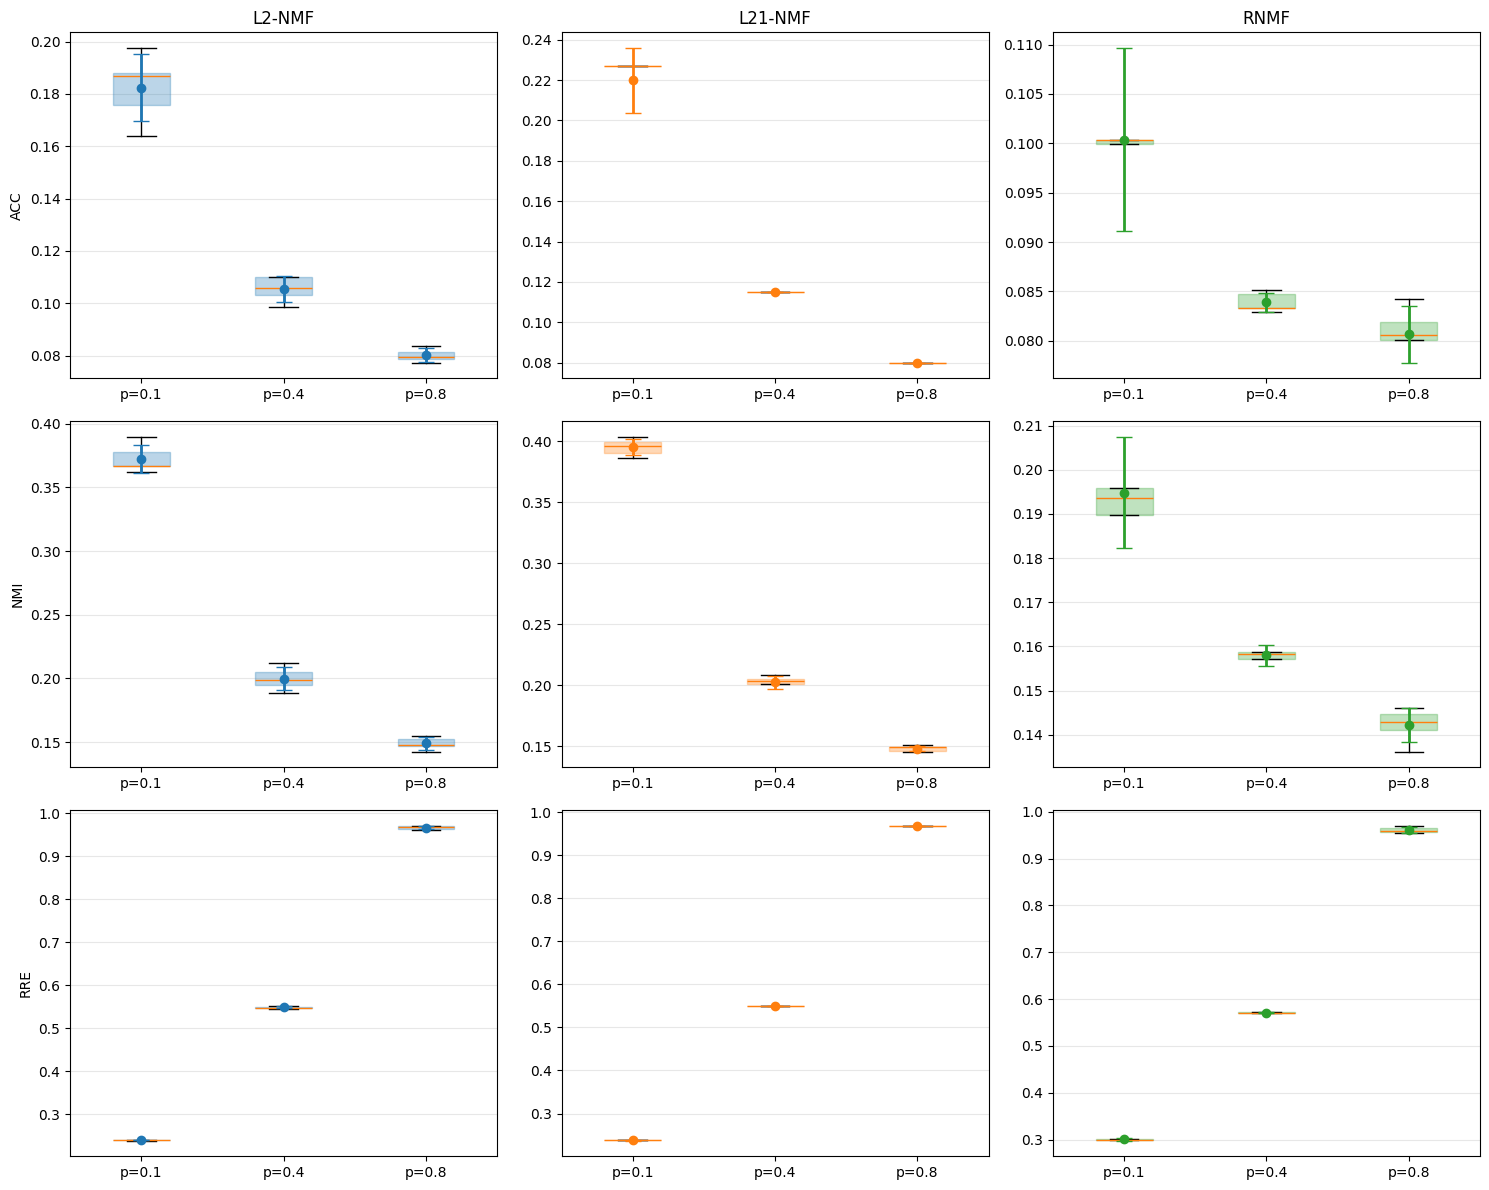

In [20]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=False)

metric_rows = [("ACC", "ACC (Yale, pepper)"),
               ("NMI", "NMI (Yale, pepper)"),
               ("RRE", "RRE (Yale, pepper)")]

alg_order = [name for name in ["L2-NMF", "L21-NMF", "RNMF"]
             if name in box_results.get("Yale", {}).get("pepper", {})]

color_map = {"L2-NMF": "tab:blue", "L21-NMF": "tab:orange", "RNMF": "tab:green"}

default_p_vals = [0.05, 0.10, 0.15]
if alg_order:  
    keys0 = list(box_results["Yale"]["pepper"][alg_order[0]].keys())
    p_vals = []
    for k in keys0:
        if isinstance(k, tuple) and len(k) >= 1:
            p_vals.append(float(k[0]))
        elif isinstance(k, (float, int)):
            p_vals.append(float(k))
    p_vals = sorted(set(p_vals))
    if not p_vals:
        p_vals = default_p_vals
else:
    pvals = default_p_vals

pos = [0.2, 0.5, 0.8][:len(p_vals)]
tick_labels = [f"p={p}" for p in p_vals]

for r, (metric, _) in enumerate(metric_rows):
    for c, alg_name in enumerate(alg_order):
        ax = axes[r, c]

        cells, chosen_keys = [], []
        for p in p_vals:
            candidates = []
            for k in box_results["Yale"]["pepper"][alg_name].keys():
                if isinstance(k, tuple) and len(k) >= 1 and np.isclose(float(k[0]), p):
                    candidates.append(k)
                elif isinstance(k, (float, int)) and np.isclose(float(k), p):
                    candidates.append(k)
            if not candidates:
                continue
            key = sorted(candidates, key=lambda t: (t if isinstance(t, tuple) else (t,)))[0]
            chosen_keys.append(key)
            cells.append(np.asarray(box_results["Yale"]["pepper"][alg_name][key][metric], dtype=float))

        if len(cells) == 0:
            ax.set_visible(False)
            continue

        bp = ax.boxplot(
            cells,
            positions=pos[:len(cells)],
            patch_artist=True,
            showfliers=False,
            widths=0.12,
            tick_labels=tick_labels[:len(cells)]
        )
        for patch in bp["boxes"]:
            patch.set_facecolor(color_map[alg_name])
            patch.set_edgecolor(color_map[alg_name])
            patch.set_alpha(0.30)

        for x, key in zip(pos[:len(chosen_keys)], chosen_keys):
            m  = float(box_results["Yale"]["pepper"][alg_name][key][f"{metric}_m"])
            sd = float(box_results["Yale"]["pepper"][alg_name][key][f"{metric}_sd"])
            ax.errorbar(x, m, yerr=sd, fmt="o", ms=6, lw=2,
                        color=color_map[alg_name], capsize=6, zorder=3)

        if r == 0:
            ax.set_title(alg_name)
        if c == 0:
            ax.set_ylabel(metric)
        ax.set_xlim(0.05, 0.95)
        ax.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

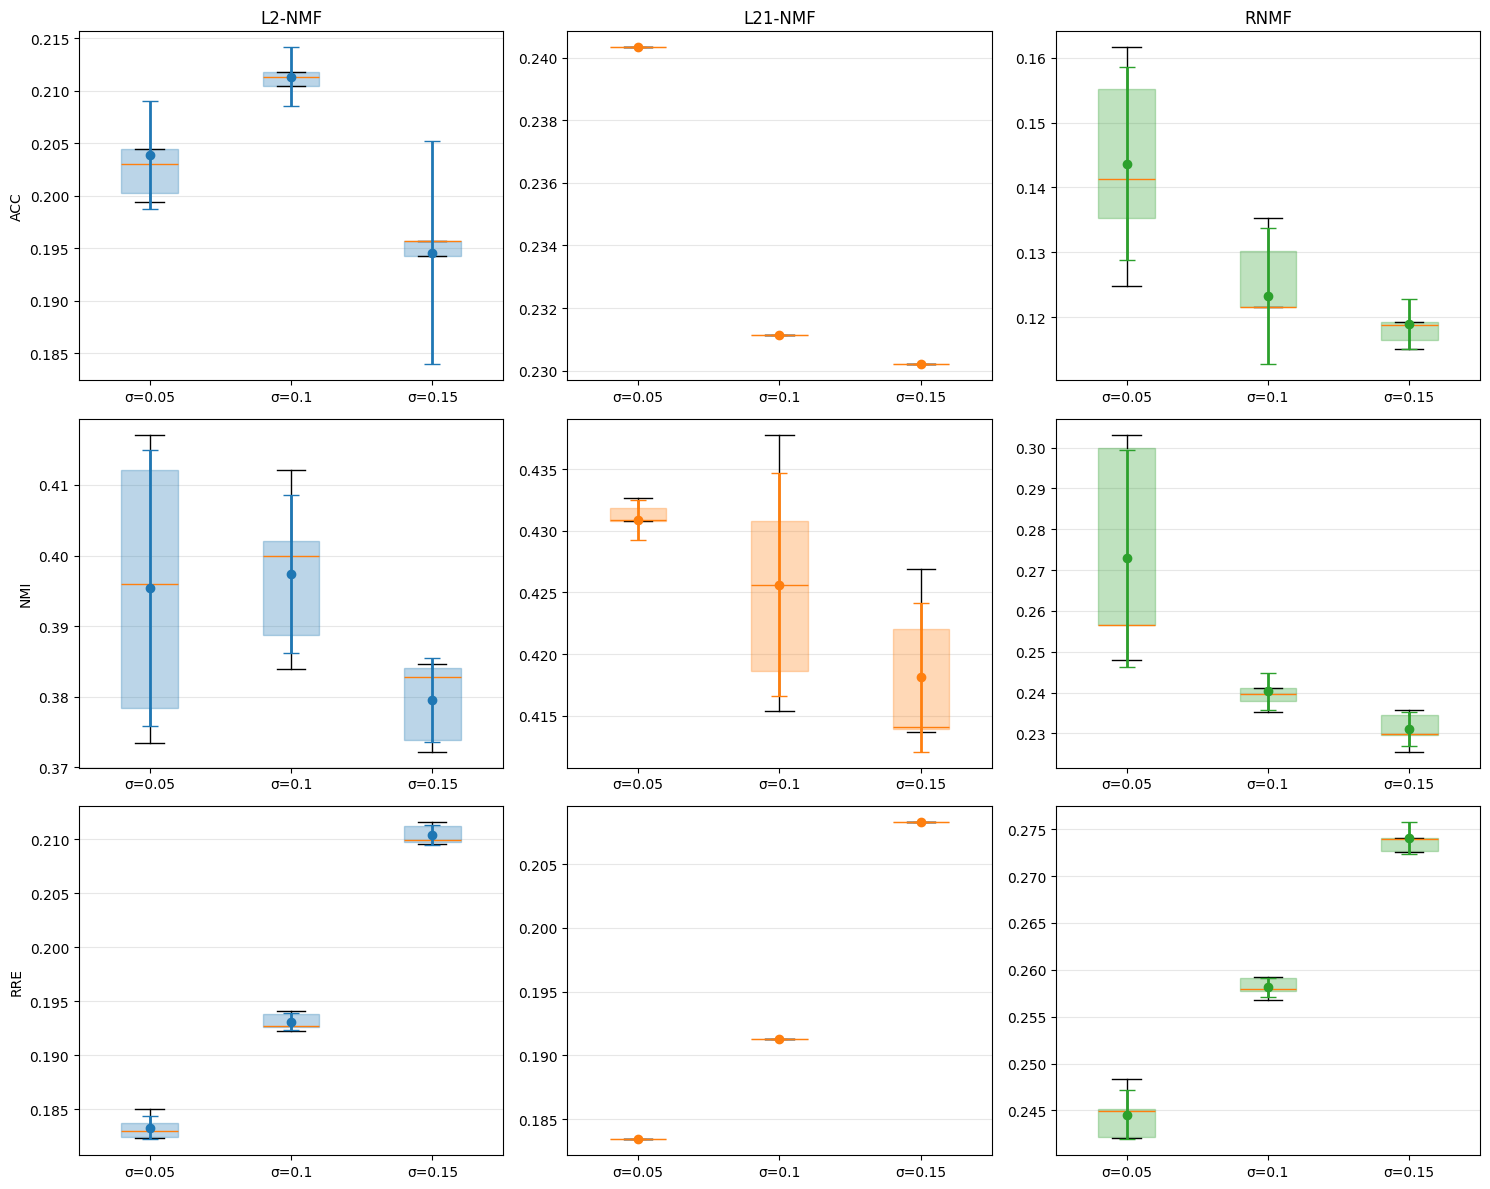

In [21]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=False)

metric_rows = [("ACC", "ACC (Yale, Gaussian)"),
               ("NMI", "NMI (Yale, Gaussian)"),
               ("RRE", "RRE (Yale, Gaussian)")]

alg_order = [name for name in ["L2-NMF", "L21-NMF", "RNMF"]
             if name in box_results.get("Yale", {}).get("gaussian", {})]

color_map = {"L2-NMF": "tab:blue", "L21-NMF": "tab:orange", "RNMF": "tab:green"}

default_sigma_vals = [0.05, 0.10, 0.15]
if alg_order:  
    keys0 = list(box_results["Yale"]["gaussian"][alg_order[0]].keys())
    sigma_vals = []
    for k in keys0:
        if isinstance(k, tuple) and len(k) >= 1:
            sigma_vals.append(float(k[0]))
        elif isinstance(k, (float, int)):
            sigma_vals.append(float(k))
    sigma_vals = sorted(set(sigma_vals))
    if not sigma_vals:
        sigma_vals = default_sigma_vals
else:
    sigma_vals = default_sigma_vals

pos = [0.2, 0.5, 0.8][:len(sigma_vals)]
tick_labels = [f"σ={sigma}" for sigma in sigma_vals]

for r, (metric, _) in enumerate(metric_rows):
    for c, alg_name in enumerate(alg_order):
        ax = axes[r, c]

        cells, chosen_keys = [], []
        for sigma in sigma_vals:
            candidates = []
            for k in box_results["Yale"]["gaussian"][alg_name].keys():
                if isinstance(k, tuple) and len(k) >= 1 and np.isclose(float(k[0]), sigma):
                    candidates.append(k)
                elif isinstance(k, (float, int)) and np.isclose(float(k), sigma):
                    candidates.append(k)
            if not candidates:
                continue
            key = sorted(candidates, key=lambda t: (t if isinstance(t, tuple) else (t,)))[0]
            chosen_keys.append(key)
            cells.append(np.asarray(box_results["Yale"]["gaussian"][alg_name][key][metric], dtype=float))

        if len(cells) == 0:
            ax.set_visible(False)
            continue

        bp = ax.boxplot(
            cells,
            positions=pos[:len(cells)],
            patch_artist=True,
            showfliers=False,
            widths=0.12,
            tick_labels=tick_labels[:len(cells)]
        )
        for patch in bp["boxes"]:
            patch.set_facecolor(color_map[alg_name])
            patch.set_edgecolor(color_map[alg_name])
            patch.set_alpha(0.30)

        for x, key in zip(pos[:len(chosen_keys)], chosen_keys):
            m  = float(box_results["Yale"]["gaussian"][alg_name][key][f"{metric}_m"])
            sd = float(box_results["Yale"]["gaussian"][alg_name][key][f"{metric}_sd"])
            ax.errorbar(x, m, yerr=sd, fmt="o", ms=6, lw=2,
                        color=color_map[alg_name], capsize=6, zorder=3)

        if r == 0:
            ax.set_title(alg_name)
        if c == 0:
            ax.set_ylabel(metric)
        ax.set_xlim(0.05, 0.95)
        ax.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

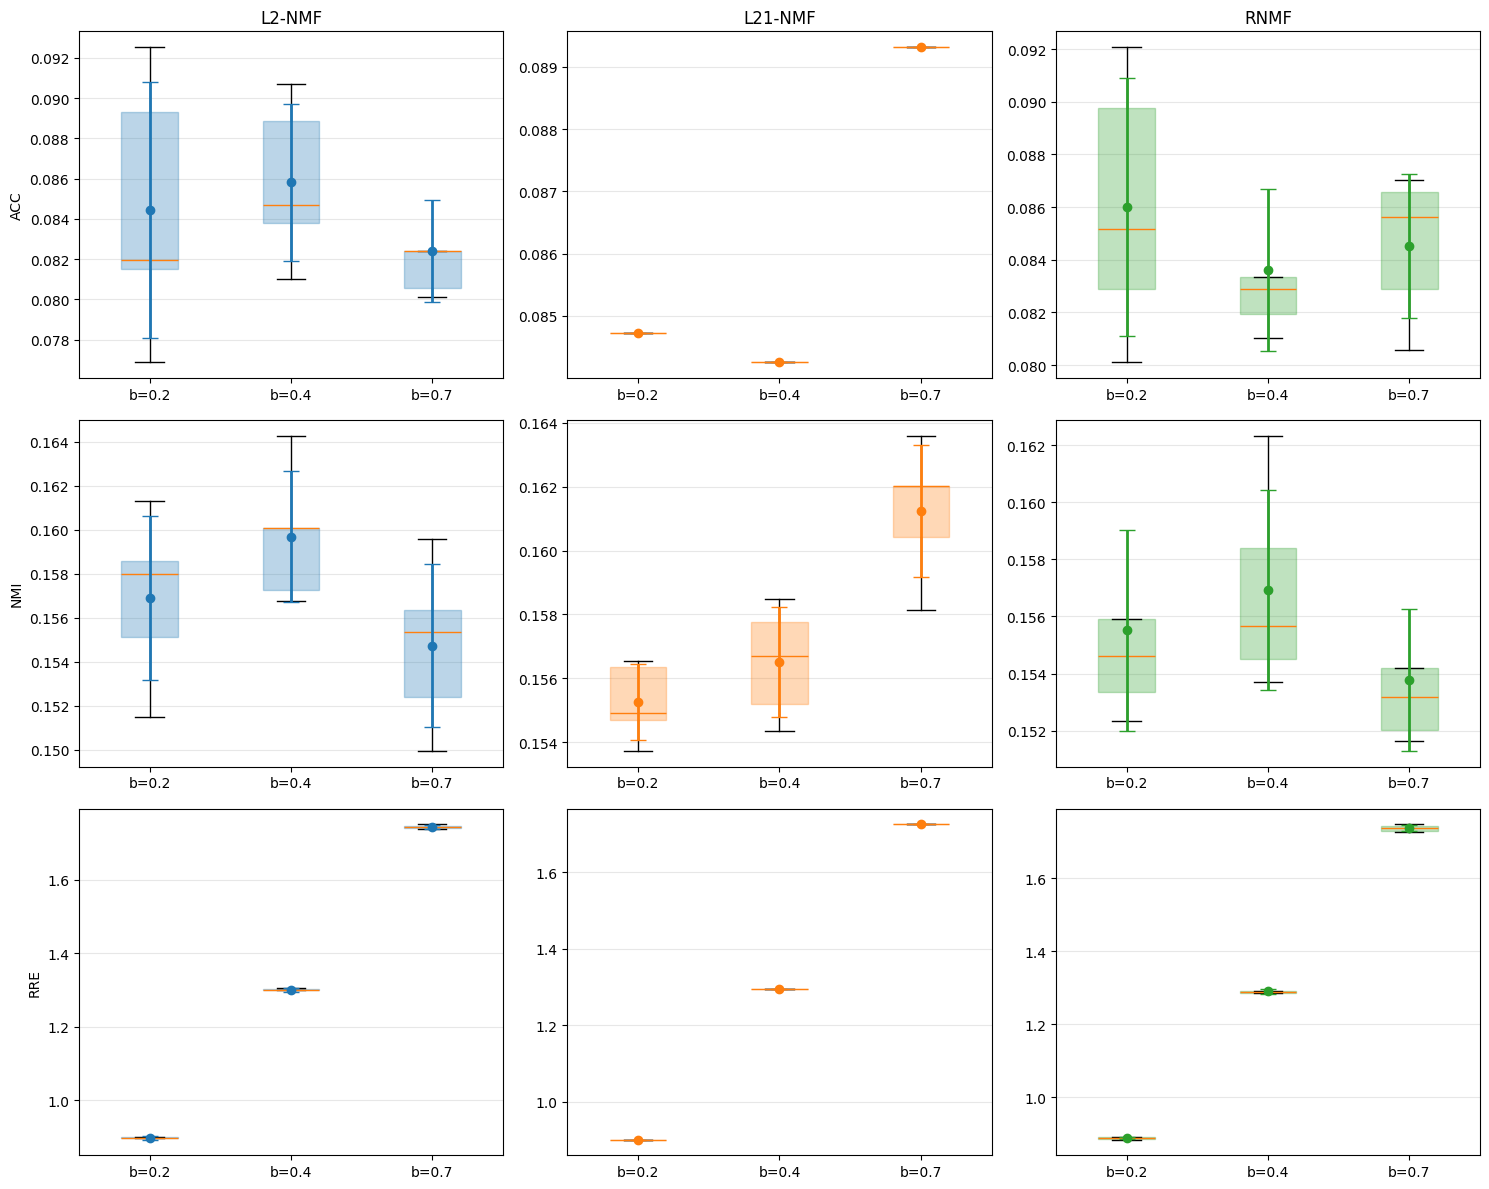

In [22]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=False)

metric_rows = [("ACC", "ACC (Yale, Block)"),
               ("NMI", "NMI (Yale, Block)"),
               ("RRE", "RRE (Yale, Block)")]

alg_order = [name for name in ["L2-NMF", "L21-NMF", "RNMF"]
             if name in box_results.get("Yale", {}).get("block", {})]

color_map = {"L2-NMF": "tab:blue", "L21-NMF": "tab:orange", "RNMF": "tab:green"}

default_block_vals = [0.2, 0.4, 0.7]
if alg_order:  
    keys0 = list(box_results["Yale"]["block"][alg_order[0]].keys())
    block_vals = []
    for k in keys0:
        if isinstance(k, tuple) and len(k) >= 1:
            block_vals.append(float(k[0]))
        elif isinstance(k, (float, int)):
            block_vals.append(float(k))
    block_vals = sorted(set(block_vals))
    if not block_vals:
        block_vals = default_block_vals
else:
    block_vals = default_block_vals

pos = [0.2, 0.5, 0.8][:len(block_vals)]
tick_labels = [f"b={b}" for b in block_vals]

for r, (metric, _) in enumerate(metric_rows):
    for c, alg_name in enumerate(alg_order):
        ax = axes[r, c]

        cells, chosen_keys = [], []
        for b in block_vals:
            candidates = []
            for k in box_results["Yale"]["block"][alg_name].keys():
                if isinstance(k, tuple) and len(k) >= 1 and np.isclose(float(k[0]), b):
                    candidates.append(k)
                elif isinstance(k, (float, int)) and np.isclose(float(k), b):
                    candidates.append(k)
            if not candidates:
                continue
            key = sorted(candidates, key=lambda t: (t if isinstance(t, tuple) else (t,)))[0]
            chosen_keys.append(key)
            cells.append(np.asarray(box_results["Yale"]["block"][alg_name][key][metric], dtype=float))

        if len(cells) == 0:
            ax.set_visible(False)
            continue

        bp = ax.boxplot(
            cells,
            positions=pos[:len(cells)],
            patch_artist=True,
            showfliers=False,
            widths=0.12,
            tick_labels=tick_labels[:len(cells)]
        )
        for patch in bp["boxes"]:
            patch.set_facecolor(color_map[alg_name])
            patch.set_edgecolor(color_map[alg_name])
            patch.set_alpha(0.30)

        for x, key in zip(pos[:len(chosen_keys)], chosen_keys):
            m  = float(box_results["Yale"]["block"][alg_name][key][f"{metric}_m"])
            sd = float(box_results["Yale"]["block"][alg_name][key][f"{metric}_sd"])
            ax.errorbar(x, m, yerr=sd, fmt="o", ms=6, lw=2,
                        color=color_map[alg_name], capsize=6, zorder=3)

        if r == 0:
            ax.set_title(alg_name)
        if c == 0:
            ax.set_ylabel(metric)
        ax.set_xlim(0.05, 0.95)
        ax.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
D_orl,  R_orl  = 37, 30
D_yale, R_yale = 48, 42

# ps: 0.1 0.6, 0.4 0.6, 0.8 0.6
p_list   = {0.1, 0.4, 0.8}
s   = 0.6
# 0.05 0.1 0.15
sigma_list   = {0.05, 0.10, 0.15}
# 20% 40% 70%
b_list = {0.2, 0.4, 0.7}
fill = 1.0

datasets = {
    "ORL":  (X_hat_orl,  Y_hat_orl,  D_orl,  R_orl),
    "Yale": (X_hat_yale, Y_hat_yale, D_yale, R_yale),
}

algorithms = []
if 'l2_nmf' in globals():
    algorithms.append(("L2-NMF",lambda X, k, max_iter=150, tol=1e-4, seed=0, **kwargs: l2_nmf(X, k, max_iter=max_iter, tol=tol, seed=seed)))

if 'L21_Norm_NMF' in globals():
    algorithms.append(("L21-NMF",lambda X, k, max_iter=150, tol=1e-4, seed=0, Y=None, **kwargs: L21_Norm_NMF(X, r=k, Iter=max_iter, Convergent=tol, Y=Y)))

if 'rnmf' in globals():
    algorithms.append(("RNMF",lambda X, k, max_iter=150, tol=1e-4, seed=0, **kwargs: rnmf(X, k, max_iter=max_iter, tol=tol, seed=seed)))

repeats = 5
k_fixed = 60

all_results = {ds_name: {"pepper": {}, "gaussian": {}, "block": {}}
               for ds_name in datasets.keys()}

for ds_name, (Xh, Yh, Dd, Rr) in datasets.items():

    # 1) add pepper
    for p in p_list:
        noiser_pepper = (lambda img: add_salt_and_pepper_noise(img, p, s))

        per_alg = {}
        for alg_name, alg_fn in algorithms:
            RREs, ACCs, NMIs, _, _, _ = eval_one_noise(
                Xh, Yh, Dd, Rr,
                noiser=noiser_pepper, k=k, algorithm=alg_fn,
                repeats=repeats, show_index=2
            )
            per_alg[alg_name] = {
                "RRE": np.mean(RREs), "RRE_sd": np.std(RREs, ddof=1),
                "ACC": np.mean(ACCs), "ACC_sd": np.std(ACCs, ddof=1),
                "NMI": np.mean(NMIs), "NMI_sd": np.std(NMIs, ddof=1)
            }
        all_results[ds_name]["pepper"][(p, s)] = per_alg

    # 2) add gaussian
    for sigma in sigma_list:
        noiser_gaussian  = (lambda img: add_gaussian_noise(img, sigma))

        per_alg = {}
        for alg_name, alg_fn in algorithms:
            RREs, ACCs, NMIs, _, _, _ = eval_one_noise(
                Xh, Yh, Dd, Rr,
                noiser=noiser_gaussian , k=k, algorithm=alg_fn,
                repeats=repeats, show_index=2
            )
            per_alg[alg_name] = {
                "RRE":
                np.mean(RREs), "RRE_sd": np.std(RREs, ddof=1),
                "ACC": np.mean(ACCs), "ACC_sd": np.std(ACCs, ddof=1),
                "NMI": np.mean(NMIs), "NMI_sd": np.std(NMIs, ddof=1)
            }
        all_results[ds_name]["gaussian"][sigma] = per_alg

    # 3) add block
    for b in b_list:
        noiser_block  = (lambda img: add_block_occlusion(img, b, fill))

        per_alg = {}
        for alg_name, alg_fn in algorithms:
            RREs, ACCs, NMIs, _, _, _ = eval_one_noise(
                Xh, Yh, Dd, Rr,
                noiser=noiser_block , k=k, algorithm=alg_fn,
                repeats=repeats, show_index=2
            )
            per_alg[alg_name] = {
                "RRE": np.mean(RREs), "RRE_sd": np.std(RREs, ddof=1),
                "ACC": np.mean(ACCs), "ACC_sd": np.std(ACCs, ddof=1),
                "NMI": np.mean(NMIs), "NMI_sd": np.std(NMIs, ddof=1)
            }
        all_results[ds_name]["block"][b, fill] = per_alg


KeyboardInterrupt: 

In [ ]:
print(all_results["ORL"])

{'pepper': {(0.1, 0.6): {'RRE': np.float64(0.19962154137698168), 'ACC': np.float64(0.6435), 'NMI': np.float64(0.7840305246336683)}, (0.4, 0.6): {'RRE': np.float64(0.3677897140365766), 'ACC': np.float64(0.23200000000000004), 'NMI': np.float64(0.4557050832484163)}, (0.8, 0.6): {'RRE': np.float64(0.5464527251943088), 'ACC': np.float64(0.16999999999999998), 'NMI': np.float64(0.3978322266393588)}}, 'gaussian': {0.05: {'RRE': np.float64(0.14853500406899317), 'ACC': np.float64(0.7075), 'NMI': np.float64(0.8488005090327103)}, 0.1: {'RRE': np.float64(0.15848164359982625), 'ACC': np.float64(0.7095), 'NMI': np.float64(0.839915676088979)}, 0.15: {'RRE': np.float64(0.17654533339200595), 'ACC': np.float64(0.6759999999999999), 'NMI': np.float64(0.816790806484381)}}, 'block': {(0.2, 1.0): {'RRE': np.float64(0.47151465471302156), 'ACC': np.float64(0.1975), 'NMI': np.float64(0.421372505767369)}, (0.4, 1.0): {'RRE': np.float64(0.6698936544881136), 'ACC': np.float64(0.184), 'NMI': np.float64(0.41320384568

In [ ]:
for ds_name, total in all_results.items():
    print(f"\n========= Dataset: {ds_name} =========")
    print("==> Apply  L2-NMF ...")
    #print(f"D.shape={D_shape}, R.shape={R_shape}")
    print("==> Evaluate RRE, ACC and NMI: format: MEAN/SD")
    for noise_type, params in all_results[ds_name].items():
        for noise_para, outcome in params.items():
            print(f"{noise_type} {noise_para} = RRE: {outcome['RRE']:.6f}/{outcome['RRE_sd']:.6f}, ACC: {outcome['ACC']:.6f}/{outcome['ACC_sd']:.6f}, NMI: {outcome['NMI']:.6f}/{outcome['NMI_sd']:.6f}")


========= Dataset: ORL =========
==> Apply  L2-NMF ...
==> Evaluate RRE, ACC and NMI
pepper (0.1, 0.6) = RRE: 0.199622, ACC: 0.643500, NMI: 0.784031
pepper (0.4, 0.6) = RRE: 0.367790, ACC: 0.232000, NMI: 0.455705
pepper (0.8, 0.6) = RRE: 0.546453, ACC: 0.170000, NMI: 0.397832
gaussian 0.05 = RRE: 0.148535, ACC: 0.707500, NMI: 0.848801
gaussian 0.1 = RRE: 0.158482, ACC: 0.709500, NMI: 0.839916
gaussian 0.15 = RRE: 0.176545, ACC: 0.676000, NMI: 0.816791
block (0.2, 1.0) = RRE: 0.471515, ACC: 0.197500, NMI: 0.421373
block (0.4, 1.0) = RRE: 0.669894, ACC: 0.184000, NMI: 0.413204
block (0.7, 1.0) = RRE: 0.967676, ACC: 0.179000, NMI: 0.407300

========= Dataset: Yale =========
==> Apply  L2-NMF ...
==> Evaluate RRE, ACC and NMI
pepper (0.1, 0.6) = RRE: 0.245383, ACC: 0.167523, NMI: 0.268616
pepper (0.4, 0.6) = RRE: 0.536152, ACC: 0.100249, NMI: 0.142430
pepper (0.8, 0.6) = RRE: 0.953474, ACC: 0.077630, NMI: 0.090229
gaussian 0.05 = RRE: 0.200735, ACC: 0.181607, NMI: 0.291268
gaussian 0.1 = 

In [ ]:
def plot_comparison(all_results, metric="ACC"):
    datasets = list(all_results.keys())
    colors = {"pepper": "#414ba5c2", "gaussian": "#61da67c2", "block": "#eb6e6ec2"}
    bg_colors = {"ORL": "#00000049", "Yale": "#ffffff6f"}

    fig, axes = plt.subplots(1, len(datasets), figsize=(14,6), sharey=True)

    for i, ds_name in enumerate(datasets):
        ax = axes[i]
        ax.set_facecolor(bg_colors[ds_name])
        ax.set_title(f"{ds_name} - {metric}")

        results = []
        labels = []
        color_list = []

        for noise_type, params in all_results[ds_name].items():
            for param, metrics in params.items():
                results.append(metrics[metric])
                labels.append(f"{noise_type}-{param}")
                color_list.append(colors[noise_type])

        # bar plot
        bars = ax.bar(range(len(results)), results, color=color_list)
        ax.set_xticks(range(len(results)))
        ax.set_xticklabels(labels, rotation=45, ha="right")
        ax.set_ylabel(metric)

        # mark the best result
        # RRE SMALLEST is better, ACC and NMI BIGGER is better
        best_idx = int(np.argmax(results)) if metric != "RRE" else int(np.argmin(results))
        best_val = results[best_idx]
        ax.text(best_idx, best_val + 0.01, f"★ {best_val:.3f}",
                ha="center", va="bottom", color="black", fontsize=10, fontweight="bold")
        bars[best_idx].set_edgecolor("black")
        bars[best_idx].set_linewidth(2)

    plt.tight_layout()
    plt.show()

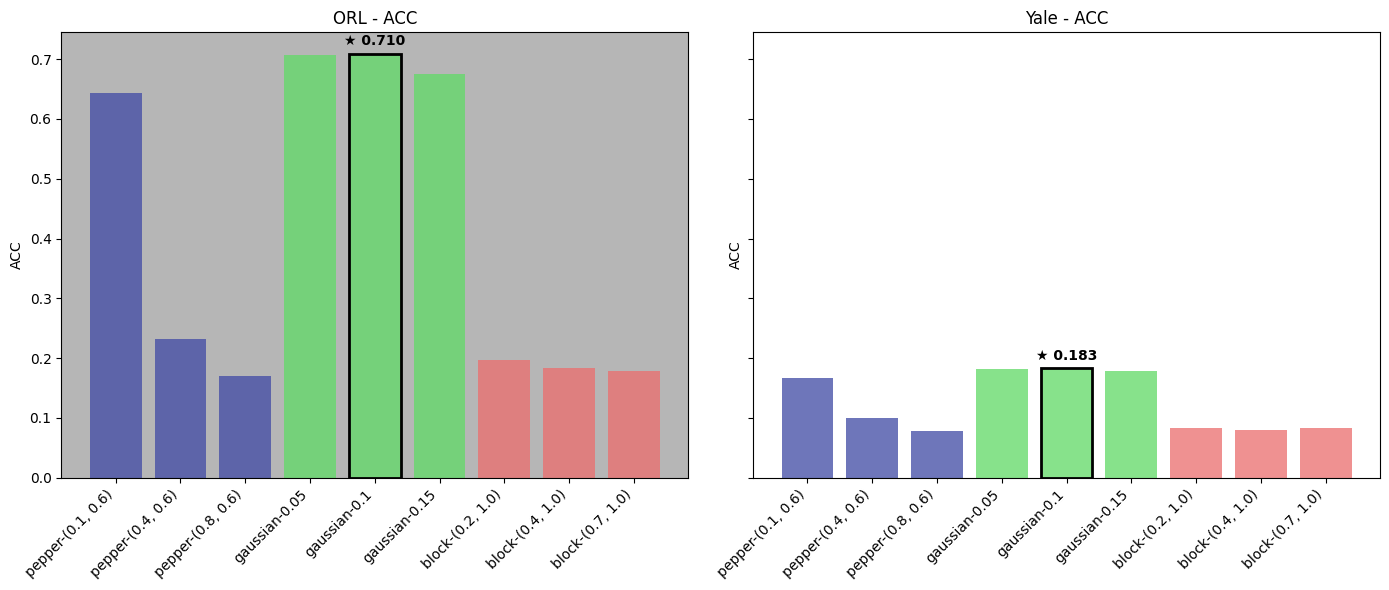

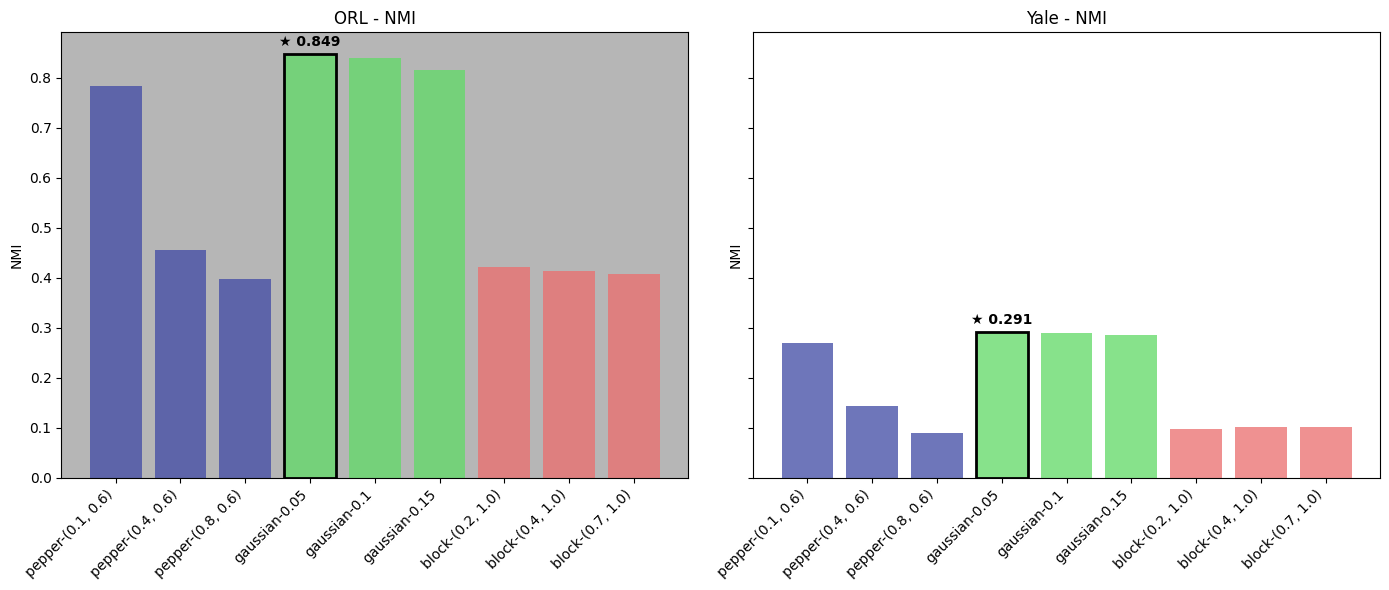

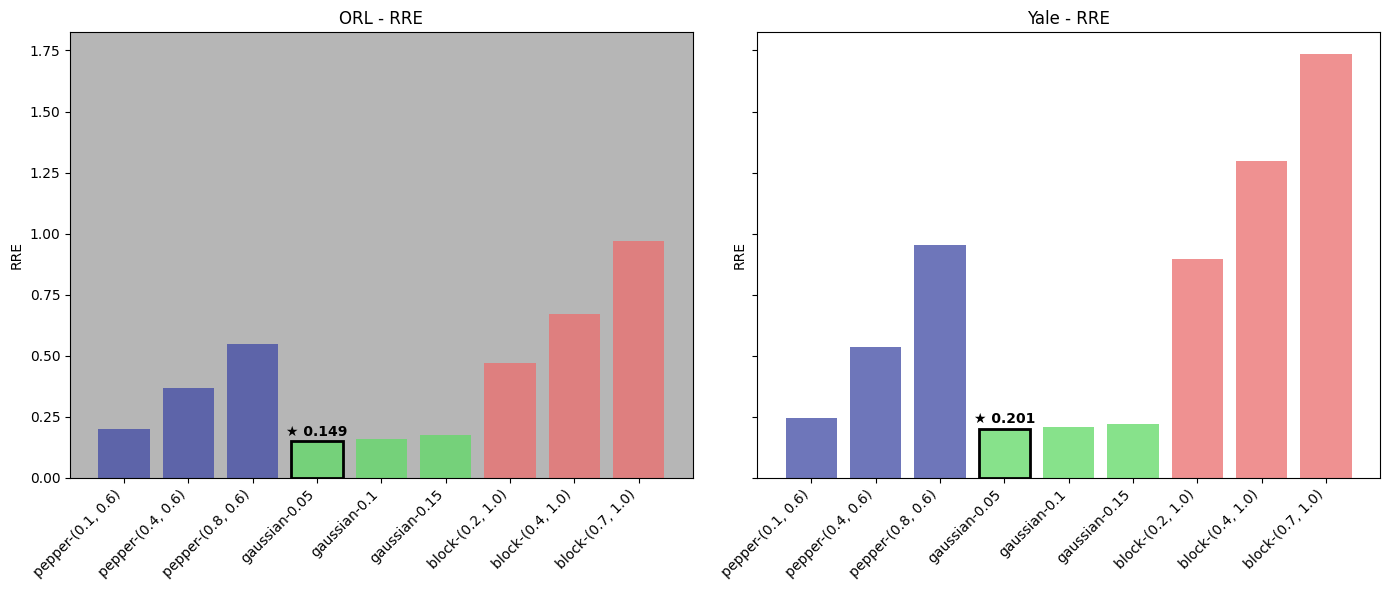

In [ ]:
plot_comparison(all_results, metric="ACC")
plot_comparison(all_results, metric="NMI")
plot_comparison(all_results, metric="RRE")